<a href="https://colab.research.google.com/github/Ausmints/lending_club/blob/main/Lending_club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting loan status, grade and interest rate

## Setting up the libraries

First we need to import all the relevant libraries as well as set up the data.

In [ ]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from AUS_Functions import *
from shapely.geometry import Polygon, MultiPolygon
import re
import joblib
import pickle

In [ ]:
sns.set()
colors = {
    "blue": "#4C72B0",
    "orange": "#DD8452",
    "green": "#55A868",
    "red": "#C44E52",
    "grey": "#8C8C8C",
    "black": "#000000",
    "blue_transparent": "#4C72B080",
}

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    OrdinalEncoder,
    OneHotEncoder,
)
from sklego.meta import Thresholder
import optuna
import shap

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
import xgboost as xg

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# First task

## Setting up the data


Since the three tasks we want to accomplish use different datasets and features in those datasets, I've split the EDA into several parts to cover only the relevant datasets and columns to the task at hand.

Data relevant to our task is split into two datasets - one containing rejected and the other containing accepted loan applications. So before we can properly do EDA, we must combine the datasets together.

Let's take a look at the rejected data first.

In [ ]:
df = pd.read_csv("data/rejected_2007_to_2018Q4.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


The dataset is quite large - there are more than 27 million entries. Taking up 2 GB of RAM, it's more than my computer can easily process. Let's see how best should we go about sampling the dataset.

In [ ]:
df.isnull().sum()

Amount Requested               0
Application Date               0
Loan Title                  1303
Risk_Score              18497630
Debt-To-Income Ratio           0
Zip Code                     293
State                         22
Employment Length         951355
Policy Code                  918
dtype: int64

We can see that there are quite a lot of missing values, especially for the "risk_score" feature. A good first step at getting a smaller dataset could be dropping the rows with missing values. However, we need to be careful with doing that - since about 2/3 of the whole dataset has missing values, by dropping them we could heavily alter the natural distributions for the features, especially, if the values are not missing completely at random.

To check, we will compare samples from untouched data and from data with dropped missing values.

In [ ]:
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()

df_sample = df.sample(frac=0.1)
df = df.dropna(axis=0)
df = df.sample(frac=0.25)

df["dropna"] = 1
df_sample["dropna"] = 0
df = pd.concat([df, df_sample])
df = df.reset_index(drop=True)
del df_sample

df.head()

,amount_requested,application_date,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length,policy_code,dropna
0,2500.0,2018-06-16,Other,572.0,0%,183xx,PA,3 years,0.0,1
1,15000.0,2017-10-16,Debt consolidation,624.0,69.61%,748xx,OK,< 1 year,0.0,1
2,5000.0,2017-11-20,Credit card refinancing,653.0,35.8%,076xx,NJ,< 1 year,0.0,1
3,10000.0,2016-11-17,Business,557.0,22.62%,945xx,CA,< 1 year,0.0,1
4,30000.0,2017-07-03,Credit card refinancing,606.0,127.04%,350xx,AL,< 1 year,0.0,1


Differences in distributions for most features were miniscule, except for the "application_date".

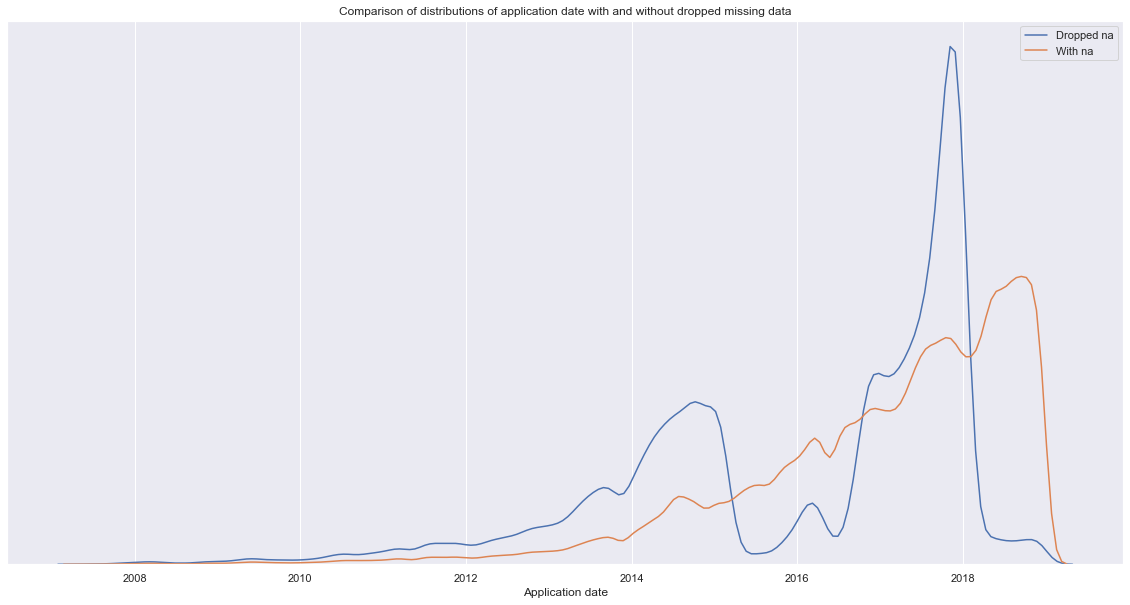

In [ ]:
df["application_date"] = pd.to_datetime(df["application_date"])
df["month"] = df["application_date"].dt.month

plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="application_date",
    hue="dropna",
    palette=[colors["orange"], colors["blue"]],
    common_norm=False,
)
plt.legend(labels=["Dropped na", "With na"], title="")
ax.set(xlabel="Application date", ylabel="")
ax.set_title(
    "Comparison of distributions of application date with and without dropped missing data"
)
ax.set_yticks([])

plt.show()

There seems to be a lot of missing data in 2015, 2016 and 2019.

Let's check the difference for the data split by month - one of the most likely ways we might use the application_date feature.

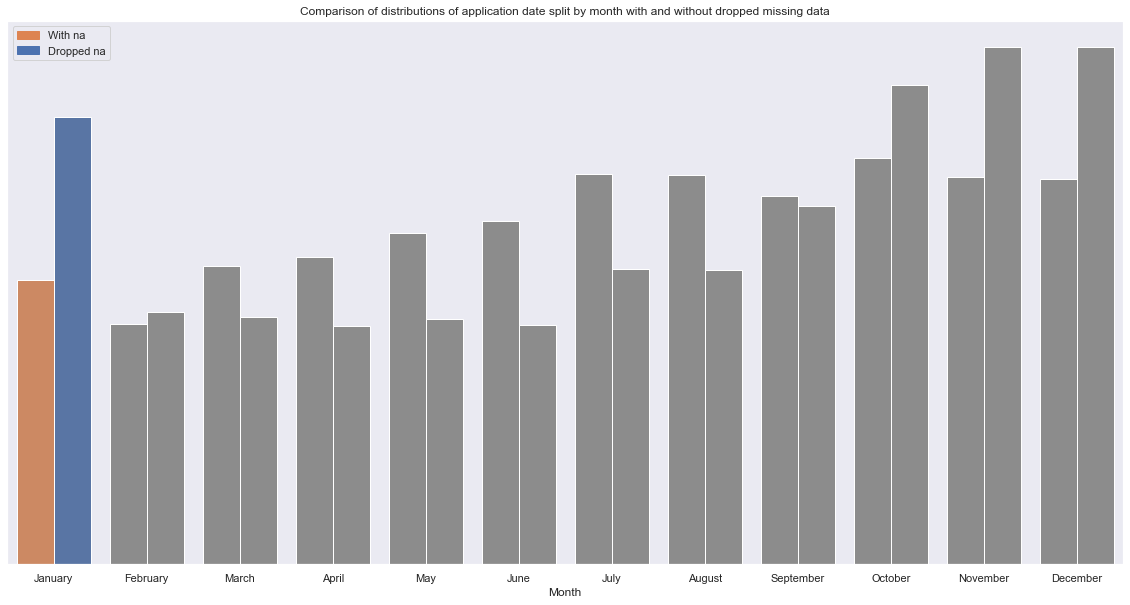

In [ ]:
df_month = df.loc[:, ["month", "dropna", "policy_code"]]
df_month.index.name = "id"
months_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}
df_month["month"] = df_month["month"].replace(months_dict)
df_month["month"] = pd.Categorical(
    df_month["month"], categories=list(list(months_dict.values()))
)

draw_comparison_barplot(
    df_month,
    "dropna",
    "month",
    ["January"],
    [
        "Comparison of distributions of application date split by month with and without dropped missing data",
        "Month",
        "",
        "With na",
        "Dropped na",
    ],
    mode="proportion",
    y_labels=False,
)

We can see that there is quite a pronounced difference in some months - the most extreme being in January.

Before we proceed let's quickly compare the date and month data between accepted and rejected datasets - to see how important the feature might be for discerning between the two.

In [ ]:
df = pd.read_csv("data/rejected_2007_to_2018Q4.csv")
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()
df = df.sample(frac=0.1)

df2 = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

df["accepted"] = 0
df2["accepted"] = 1
df = df.loc[:, ["application_date", "accepted"]]
df2 = df2.loc[:, ["issue_d", "accepted"]]
df2 = df2.rename(columns={"issue_d": "application_date"})

df = pd.concat([df, df2])
df = df.reset_index(drop=True)

df["application_date"] = pd.to_datetime(df["application_date"])
df = df.dropna(axis=0)
df["month"] = df["application_date"].dt.month
df["month"] = df["month"].replace(months_dict)
df["month"] = pd.Categorical(df["month"], categories=list(list(months_dict.values())))

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_11664\1051733384.py:5: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('data/accepted_2007_to_2018Q4.csv')


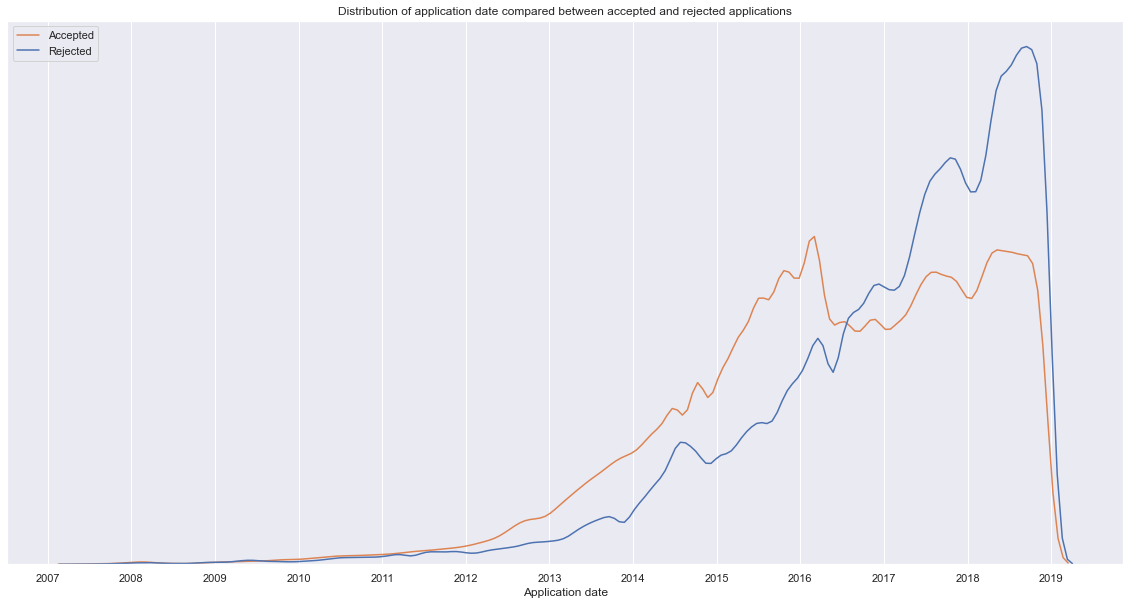

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="application_date",
    hue="accepted",
    palette=[colors["blue"], colors["orange"]],
    common_norm=False,
)
plt.legend(labels=["Accepted", "Rejected"], title="")
ax.set(xlabel="Application date", ylabel="")
ax.set_xticks(pd.to_datetime([str(2007 + x) for x in range(13)]))
ax.set_xticklabels([2007 + x for x in range(13)])
ax.set_title(
    "Distribution of application date compared between accepted and rejected applications"
)
ax.set_yticks([])

plt.show()

We can see that something must have happened to the market in 2016 (perhaps the [stock market crash due to Brexit?](https://en.wikipedia.org/wiki/2015%E2%80%932016_stock_market_selloff#:~:text=The%20vote%20led%20to%20stock,dollars%20by%20June%2027%2C%202016.) ) that made applications a lot less likely to be accepted - while the number of rejected applications has continued to grow, the amount of accepted applications hadn't recovered yet in the 2019. Excluding that the distributions seem quite alike.

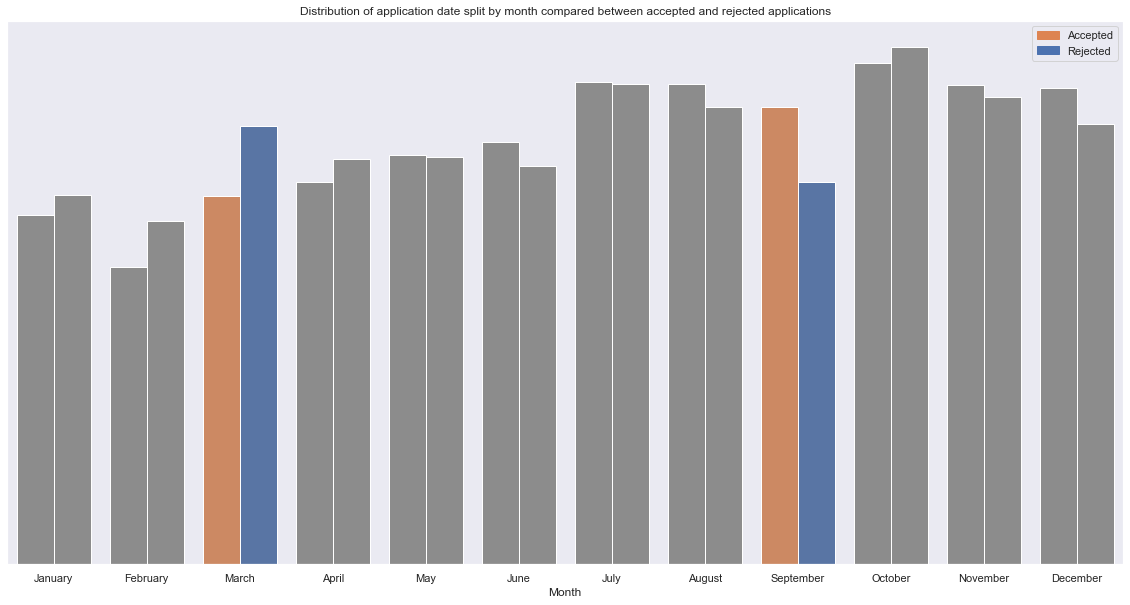

In [ ]:
df.index.name = "id"
draw_comparison_barplot(
    df,
    "accepted",
    "month",
    ["March", "September"],
    [
        "Distribution of application date split by month compared between accepted and rejected applications",
        "Month",
        "",
        "Accepted",
        "Rejected",
    ],
    mode="proportion",
    y_labels=False,
)

If we look at the difference of distributions between months, there seem to be several that contain different proportion compared to the other distribution. However, if we look at the previous graph, we can attribute the unequal proportions in March to the 2016 crash event. For September a single event is harder to spot, however, there also doesn't seem to be an obvious yearly pattern for it.

Overall, it seems like date and month data is not that important for the task and we can drop the column and all the rows with missing values. I think that the data we get will be better - since we won't have any missing data to impute and all the entries will contain actual data.

## EDA

In [ ]:
df2 = pd.read_csv("data/accepted_2007_to_2018Q4.csv")
df2 = df2_to_df(df2)
df2.shape[0]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_67632\3292299738.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("data/accepted_2007_to_2018Q4.csv")


2260701

Dataset containing accepted data has a lot of columns that are not relevant to us and the column names are different than for the rejected data, so we use a custom function that filters out the data that we need and renames the columns.

We can see that accepted dataset has only 2 million entries - a lot less than the rejected dataset even after we've excluded the missing data. To balance out the datasets and make the complete size manageable, we will be sampling the accepted dataset to approximately the same size as the rejected dataset.

In [ ]:
df = pd.read_csv("data/rejected_2007_to_2018Q4.csv")
df = df.dropna(axis=0)
df = df.sample(frac=0.25)
df.columns = df.columns.str.replace(" |-", "_", regex=True).str.lower()

df["accepted"] = 0
df = df.drop(["policy_code", "application_date"], axis=1)

We also have to drop the "policy code" feature - the feature is related to the action taken ("accepted", "rejected") and thus contains information unknown to us at the moment of prediction.

In [ ]:
df2.isnull().sum()

amount_requested            33
loan_title               23358
debt_to_income_ratio      1744
zip_code                    34
state                       33
employment_length       146940
risk_score                  33
accepted                     0
dtype: int64

We dropped all the missing entries in the rejected dataset, but there are some in the accepted dataset that we will have to deal with.

In [ ]:
df2 = df2.drop(df2[df2["amount_requested"].isnull()].index, axis=0)

df = pd.concat([df, df2])
df = df.reset_index(drop=True)

del df2

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508717 entries, 0 to 4508716
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   amount_requested      float64
 1   loan_title            object 
 2   risk_score            float64
 3   debt_to_income_ratio  object 
 4   zip_code              object 
 5   state                 object 
 6   employment_length     object 
 7   accepted              int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 275.2+ MB


After combining both the accepted data and the sample from rejected dataset, we get 4.5 million entries. Memory usage is still high due to most of the features having been designated as containing strings, but hopefully with some data cleaning and engineering we'll be able to bring it down.

In [ ]:
df.head()

,amount_requested,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length,accepted
0,1000.0,Credit card refinancing,570.0,42.82%,902xx,CA,< 1 year,0
1,40000.0,Major purchase,751.0,20%,773xx,TX,< 1 year,0
2,5000.0,debt_consolidation,579.0,34.92%,754xx,TX,< 1 year,0
3,1500.0,debt_consolidation,695.0,3.66%,954xx,CA,< 1 year,0
4,7000.0,credit_card,648.0,20.77%,891xx,NV,< 1 year,0


We can see that some of the string columns actually contain numeric data - debt_to_income_ratio column contains percentages, while employement_length contains discrete numeric data. We will use a custom function to transform the features to numeric as well as downcast all numeric columns as much as possible to minimize the memory usage of the data. Zip_code also contains numbers, but we will look at it later.

In [ ]:
df = clean_data(df)
df_copy = df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4508717 entries, 0 to 4508716
Data columns (total 8 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amount_requested         int32  
 1   loan_title               object 
 2   risk_score               float32
 3   debt_to_income_ratio     float32
 4   zip_code                 object 
 5   state                    object 
 6   employment_length_years  float32
 7   accepted                 int8   
dtypes: float32(3), int32(1), int8(1), object(3)
memory usage: 176.3+ MB


We can see that memory usage is smaller now.

In [ ]:
df.describe().apply(lambda s: s.apply("{0:.5f}".format))

,amount_requested,risk_score,debt_to_income_ratio,employment_length_years,accepted
count,4508717.00000,4508717.00000,4507006.00000,4361810.00000,4508717.00000
mean,13843.39351,664.02002,89.50935,4.06340,0.56096
std,10157.07826,77.02917,3986.81006,5.67515,0.60449
min,300.00000,0.00000,-1.00000,0.00000,0.00000
25%,5200.00000,636.00000,10.89000,0.00000,0.00000
50%,10500.00000,675.00000,18.73000,0.00000,1.00000
75%,20000.00000,702.00000,28.43000,6.00000,1.00000
max,1400000.00000,990.00000,3225600.00000,15.00000,2.00000


Some of the features - "amount_requested" and "debt_to_income_ratio" seem to be quite heavily right skewed.

In [ ]:
accepted_to_words = {0: "Rejected", 1: "Accepted", 2: "Charged off"}
df["accepted"].value_counts().rename(index=accepted_to_words)

Rejected       2248049
Accepted       1992109
Charged off     268559
Name: accepted, dtype: int64

Our target column - accepted is currently split into 3 values - rejected applications, accepted applications and accepted applications that got charged off. "Charged off" means that the applicator has been negligent to his due payments for long enough that the creditor no longer believes that the debt will be payed and cuts his losses. It might improve our model if we exclude theses failed cases.

Now that we've combined the data and cleaned up the data a bit, let's take a closer look at each of the features.

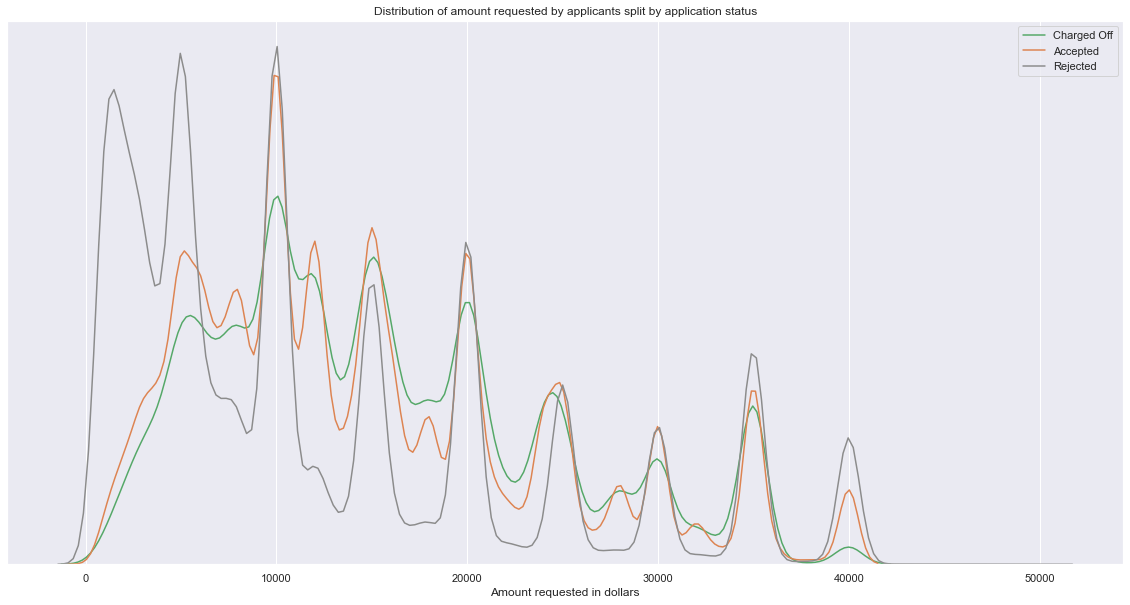

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df[df["amount_requested"] < 50000],
    x="amount_requested",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False,
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Amount requested in dollars", ylabel="")
ax.set_title(
    "Distribution of amount requested by applicants split by application status"
)
ax.set_yticks([])

plt.show()

Since amount_requested feature was so heavily skewed, to better see the differences in distributions for the main body of entries, we have excluded the long tail. There is quite a large difference in distributions from 0 to around 7000 dollars with a lot more rejected applications - seems like investors tend to not be interested in lending such small amounts. There doesn't seem to be much of a difference between accepted and charged off applications.

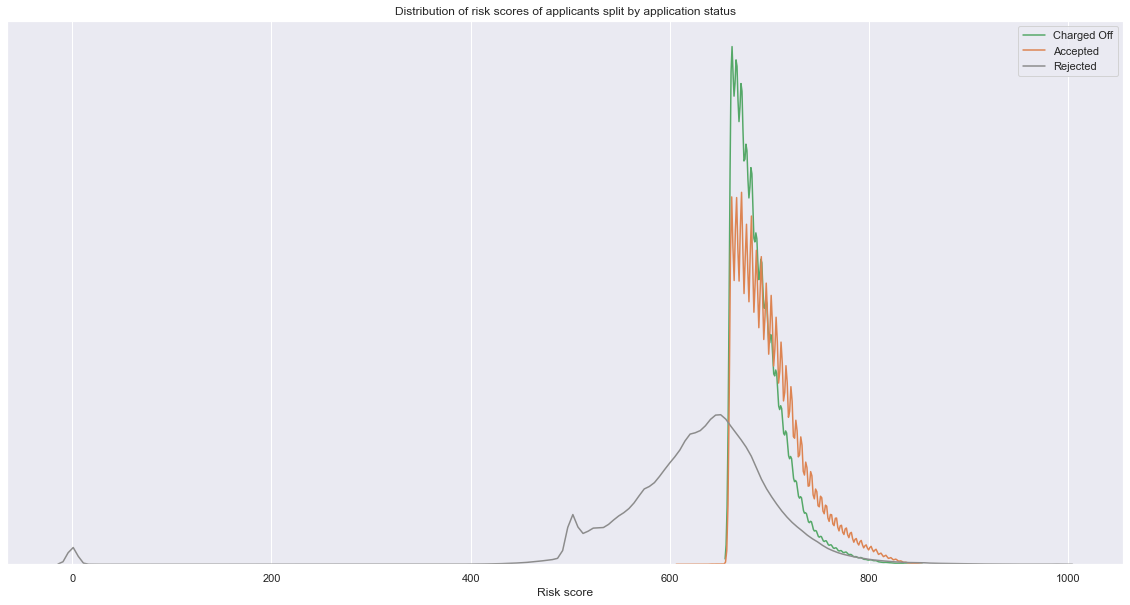

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="risk_score",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False,
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk scores of applicants split by application status")
ax.set_yticks([])
plt.show()

In [ ]:
df.loc[df["accepted"] == 1, "risk_score"].sort_values().quantile(0.0001)

647.0

For the risk_score feature we can see that the distributions are quite different. For accepted aplications there are basically no entries under risk score of 647, while the rejected values range from 400 up to over 800. Charged off entries tend to also have a smaller risk score than other accepted entries. Also there seem to be a number of entries with risk score 0 - since 0 is an invalid value for risk score, most likely given to an applicant that hasn't had his risk score measured, we'll have to treat them as missing values.

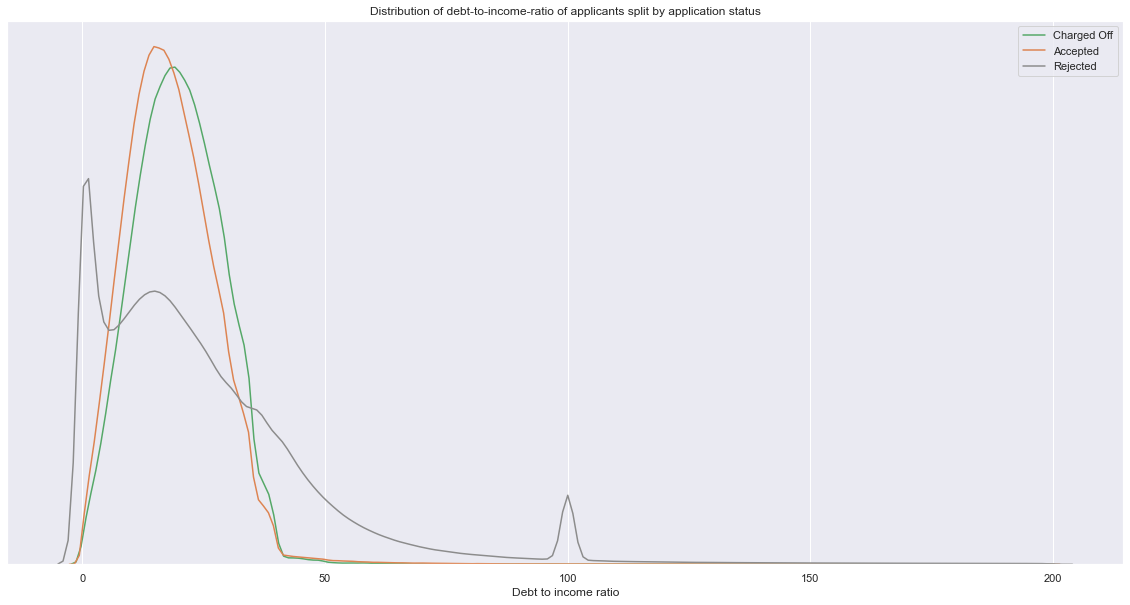

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df[df["debt_to_income_ratio"] < 200],
    x="debt_to_income_ratio",
    hue="accepted",
    palette=[colors["grey"], colors["orange"], colors["green"]],
    common_norm=False,
)
plt.legend(labels=["Charged Off", "Accepted", "Rejected"], title="")
ax.set(xlabel="Debt to income ratio", ylabel="")
ax.set_title(
    "Distribution of debt-to-income-ratio of applicants split by application status"
)
ax.set_yticks([])

plt.show()

In [ ]:
df.loc[df["debt_to_income_ratio"] < 0, "debt_to_income_ratio"].value_counts()

-1.0    3810
Name: debt_to_income_ratio, dtype: int64

Debt-to-income-ratio feature was heavily skewed, so, in order to see the difference in distributions, we will again be cutting off the long tail. We can again see quite large differences in distributions for this feature. Applicants that have debt-to-income-ratio of either 0 or above 45 seem a lot less likely to be accepted than the applicants whose debt-to-income-ratio is inbetween. Also, there seem to be some entries with a negative value, which is invalid for this feature - we will be considering those values as missing data.

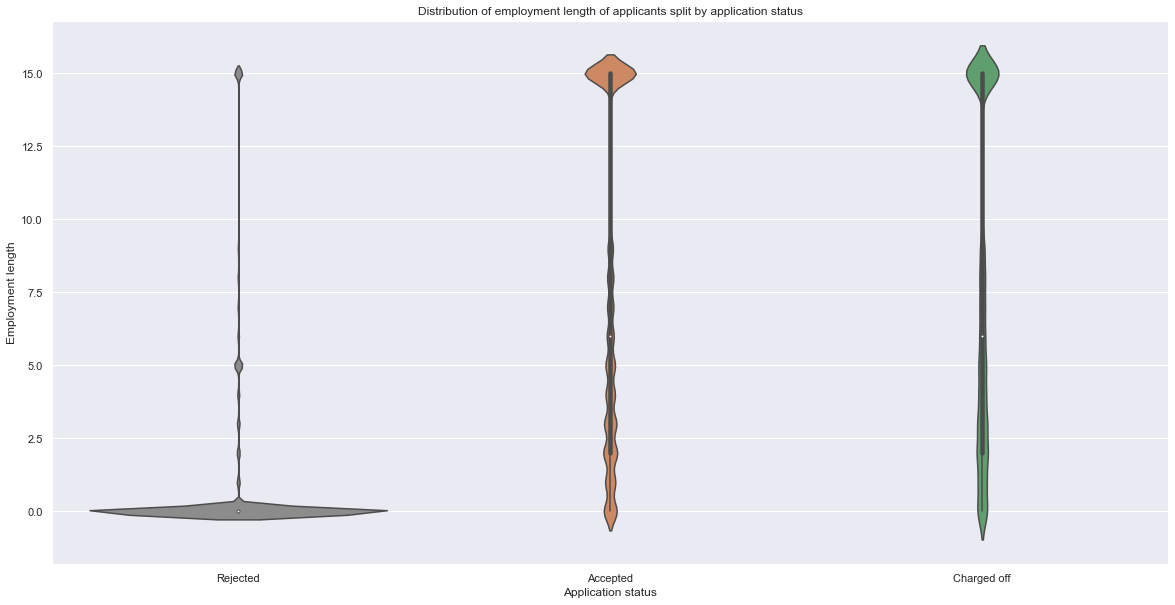

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.violinplot(
    y=df["employment_length_years"],
    x=df["accepted"].replace(accepted_to_words),
    palette=[colors["grey"], colors["orange"], colors["green"]],
)
ax.set(xlabel="Application status", ylabel="Employment length")
ax.set_title(
    "Distribution of employment length of applicants split by application status"
)

plt.show()

We can see quite extreme differences in distributions for employement_length feature. Almost all of the rejected applicants had worked in their current job for less than a year, while the majority of accepted applicants had worked in their workplace for more than 10 years.

Next let's take a look at some of the columns containing strings, starting with the loan_title column. We'll count all the different words for entries, split them by status and then check their proportions of total word count per split.

In [ ]:
word_df = (
    pd.Series(
        [y for x in df["loan_title"].dropna().values.flatten() for y in x.split()]
    )
    .value_counts()
    .to_frame("total")
)
word_df["total"] = (word_df["total"] / word_df["total"].sum()).round(3)
for index, value in enumerate(["rejected", "accepted", "charged_off"]):
    word_df[value] = pd.Series(
        [
            y
            for x in df.loc[df["accepted"] == index, "loan_title"]
            .dropna()
            .values.flatten()
            for y in x.split()
        ]
    ).value_counts()
    word_df[value] = (word_df[value] / word_df[value].sum()).round(3)

difference_words = (
    word_df[np.abs(word_df["rejected"] - word_df["accepted"]) > 0.01]
).index.to_list()

In [ ]:
word_df.head(10)

,total,rejected,accepted,charged_off
debt,0.248,0.248,0.244,0.270
consolidation,0.248,0.248,0.244,0.270
credit,0.086,0.068,0.105,0.085
card,0.085,0.067,0.103,0.082
refinancing,0.071,0.040,0.099,0.078
other,0.052,0.082,0.026,0.026
home,0.032,0.031,0.033,0.029
improvement,0.027,0.024,0.030,0.026
car,0.015,0.028,0.005,0.004
purchase,0.012,0.015,0.010,0.009


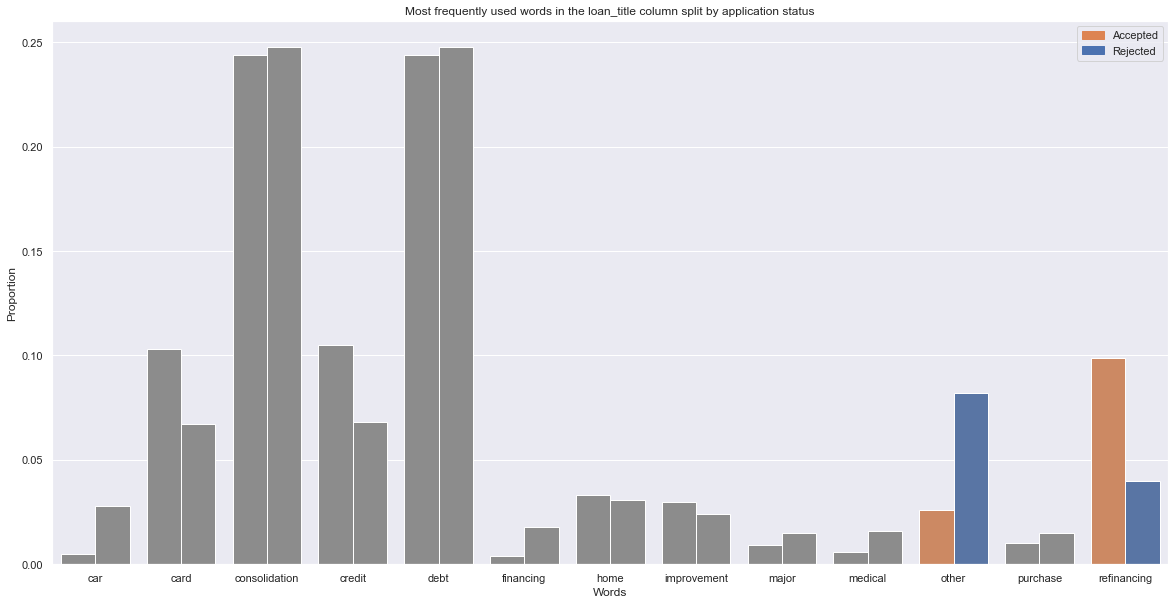

In [ ]:
word_df = word_df.loc[word_df["total"] > 0.01, ["rejected", "accepted"]]
word_df = (
    word_df.unstack()
    .reset_index()
    .rename(columns={"level_0": "accepted", "level_1": "word", 0: "count"})
)
word_df.index.name = "id"

draw_comparison_barplot(
    word_df,
    "accepted",
    "word",
    ["other", "refinancing"],
    [
        "Most frequently used words in the loan_title column split by application status",
        "Words",
        "Proportion",
        "Accepted",
        "Rejected",
    ],
    mode="",
)

We can see that some words are being used in the title a lot more frequently than others - words "debt" and "consolidation" together make up almost half of the total words used. For some words, like "other" and "refinancing", the difference in proportions is quite large and we might use them as features for our model.

Next we'll look at the state and zip_code columns.

In [ ]:
states = geopandas.read_file("data/maps/tl_2012_us_state.shp")
us_pop_df = pd.read_csv("data/2019_Census_US_Population_Data_By_State_Lat_Long.csv")

states = customize_us_shapefile(states)

loans_states_count = df.groupby("state")["accepted"].count().rename("count")
states = states.merge(loans_states_count, left_on="STUSPS", right_index=True)
states = states.merge(
    us_pop_df.set_index("STATE")["POPESTIMATE2019"],
    left_on="NAME",
    right_index=True,
    how="left",
)
states["applications_per_thousand"] = states["count"] / (
    states["POPESTIMATE2019"] / 1000
)

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.


Let's start by just plotting the absolute loan application count per state.

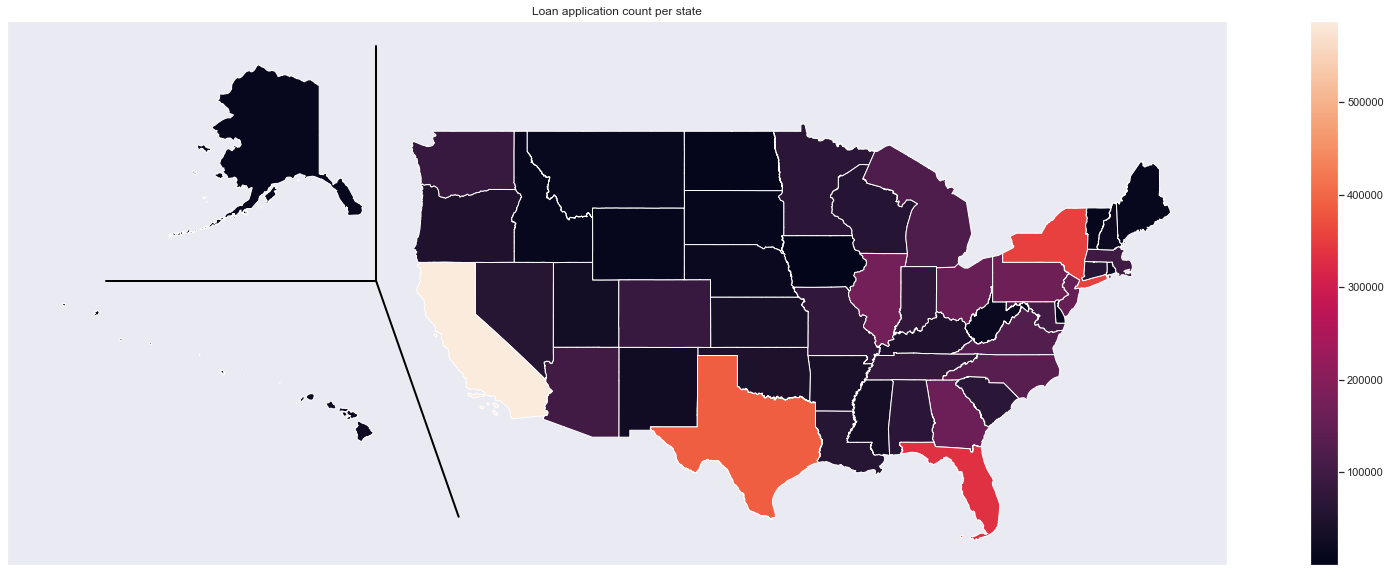

In [ ]:
draw_usa(states, "count", "Loan application count per state")

We can see that a few states - most notably California and Texas have a huge amount of loan applications. However, the absolute numbers of applications might be misleading in this case due to the differring population counts between the states.

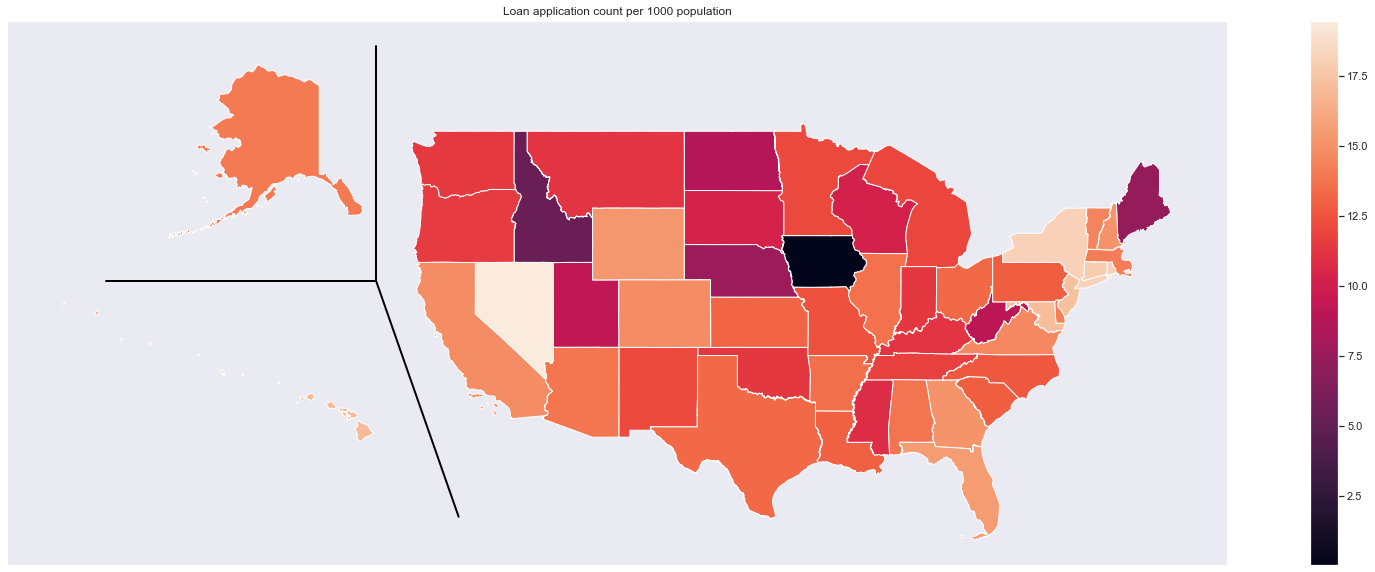

In [ ]:
draw_usa(
    states, "applications_per_thousand", "Loan application count per 1000 population"
)

If we look at a map containing normalized data - application count per 1000 population in each state - the high population states are not as prevalent as in the previous plot. There seem to be more per person applications in the New York area, but otherwise people seem to be more likely to apply for a loan in the southern part of the country compared to the more northern states. Two outlier states are Iowa with extremely low amount of applications and Nevada with the opposite - in Iowa's case it could be explained by a low population and thus a sample too small to be stable, while Nevada's high number could be explained by relatively low population combined with being adjacent to California.

Next let's look at the ratios between application statuses in each of the states.

In [ ]:
ratios_states = (
    df.groupby("state")["accepted"].value_counts().rename("count").to_frame().unstack()
)
ratios_states.columns = ratios_states.columns.get_level_values(1)
ratios_states["accepted_charged_off_ratio"] = ratios_states[2] / ratios_states[1]
ratios_states["accepted_rejected_ratio"] = ratios_states[0] / (
    ratios_states[1] + ratios_states[2]
)
ratios_states = ratios_states.drop([0, 1, 2], axis=1)

states = states.merge(ratios_states, left_on="STUSPS", right_index=True, how="left")

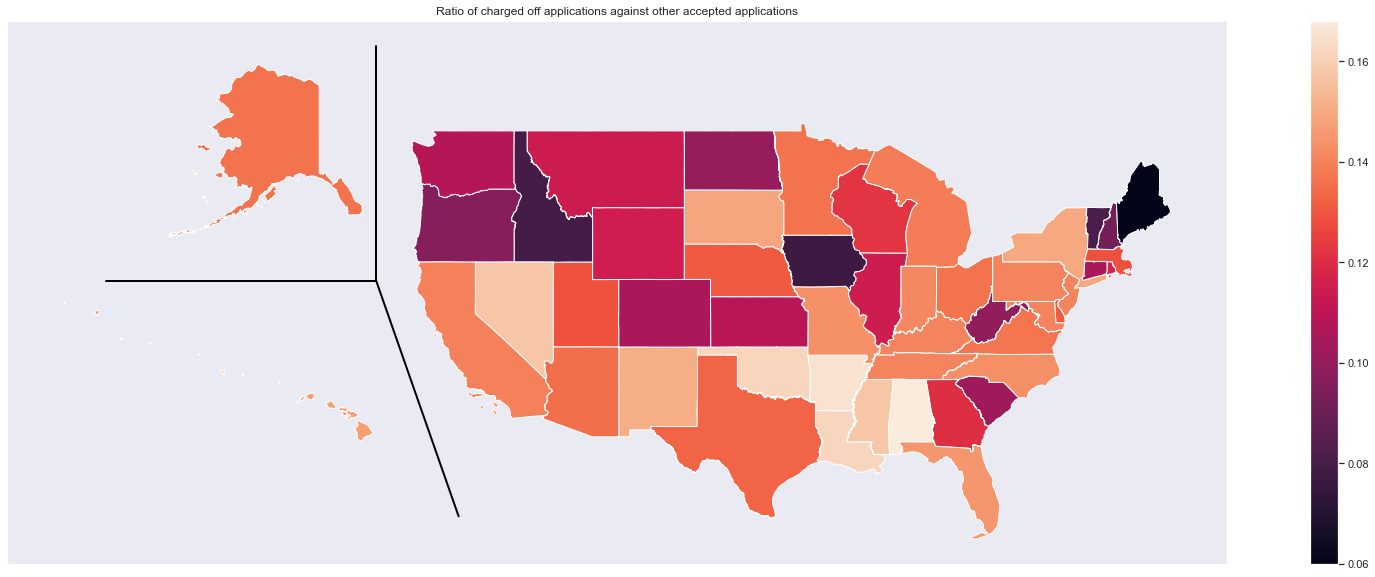

In [ ]:
draw_usa(
    states,
    "accepted_charged_off_ratio",
    "Ratio of charged off applications against other accepted applications",
)

In [ ]:
states.loc[
    states["accepted_charged_off_ratio"].sort_values(ascending=False)[:5].index
].loc[:, ["NAME", "count", "accepted_charged_off_ratio"]]

,NAME,count,accepted_charged_off_ratio
31,Alabama,67508,0.143899
1,Arkansas,41034,0.141736
17,Louisiana,60311,0.139485
14,Oklahoma,45303,0.139336
54,Nevada,59678,0.136050


Looking at the ratio between charged off and accepted applications, we again see the difference between southern and northern states with the southern part of the country having a higher charged off ratio. Especially high the ratio seems to be in the states around Alabama.

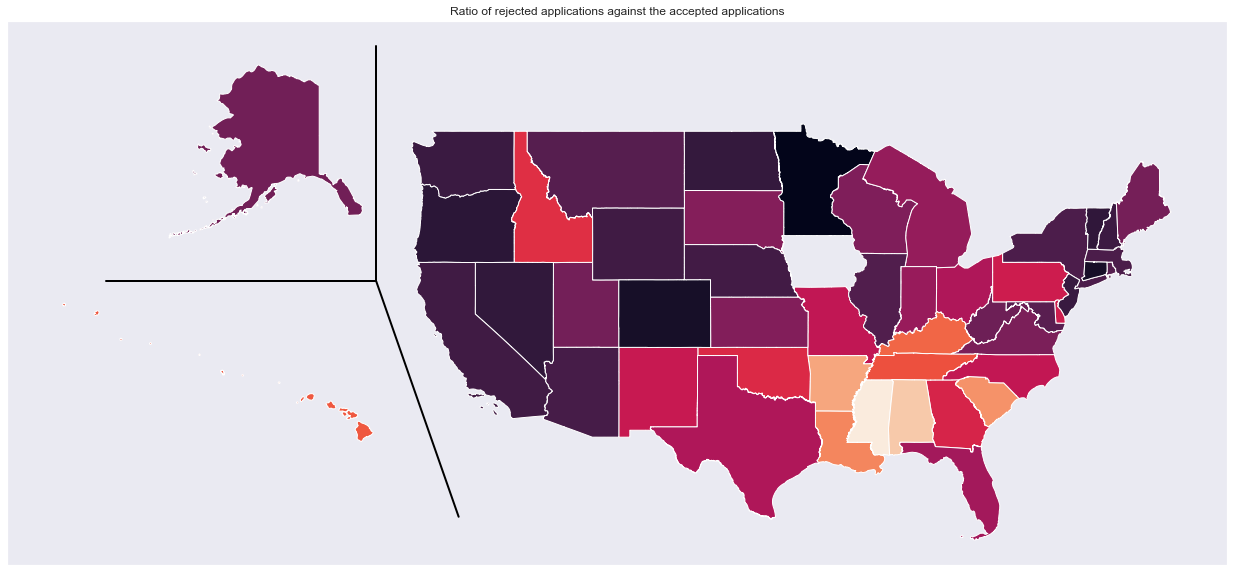

In [ ]:
draw_usa(
    states[states["NAME"] != "Iowa"],
    "accepted_rejected_ratio",
    "Ratio of rejected applications against the accepted applications",
    legend=False,
)

And here again we see that the ratio of rejected applications is especially high in the Alabama region. Note that since we are using a sample for rejected data and the complete dataset for accepted data, the ratios calculated here, while being accurate in comparison between the states are by themselves misleading, so I've excluded the legend here. Also note that we have excluded Iowa from this graph due to having an extremely low value.

And finally let's look at the zip_code.

In [ ]:
zip_df = pd.read_csv("data/US_zip_codes_coordinates.txt", sep="\t", header=None)
zip_df = zip_df.drop([0, 2, 3, 5, 6, 7, 8, 11], axis=1)
zip_df.columns = ["zip_code", "state", "latitude", "longitude"]
zip_df = zip_df.dropna(axis=0)

zip_df["bin"] = (
    np.floor(zip_df["zip_code"] / 100).astype(int).astype(str).str.zfill(3)
    + zip_df["state"]
)
state_coord_means = zip_df.groupby("state")[["latitude", "longitude"]].mean()
state_coord_means = state_coord_means.rename(
    columns={"latitude": "state_latitude", "longitude": "state_longitude"}
)
bin_coord_means = zip_df.groupby("bin")[["latitude", "longitude"]].mean()

zip_df.head()

,zip_code,state,latitude,longitude,bin
0,99553,AK,54.1430,-165.7854,995AK
1,99571,AK,55.1858,-162.7211,995AK
2,99583,AK,54.8542,-163.4113,995AK
3,99612,AK,55.0628,-162.3056,996AK
4,99661,AK,55.3192,-160.4914,996AK


Even though zip code contains numbers, they don't represent ordinal data. One way we can convert both zip codes and state names to numerical data is to look up their physical location as latitude and longitude. Since we are missing last two digits for the values in zip_code feature, we'll have to take the average geographical values between all the possible zip codes for each entry.

In [ ]:
df = zip_state_to_coordinates(df)

df.head()

,amount_requested,loan_title,risk_score,debt_to_income_ratio,state,employment_length_years,accepted,latitude,longitude,state_latitude,state_longitude
0,20000,debt consolidation,632.0,48.540001,VA,0.0,0,36.842242,-81.134800,37.714359,-78.231150
1,20000,debt consolidation,673.0,76.250000,OH,0.0,0,39.989814,-82.991341,40.387578,-82.739298
2,1000,debt consolidation,631.0,0.000000,NC,1.0,0,35.808798,-78.633634,35.573569,-79.528286
3,1000,moving,569.0,128.660004,WI,0.0,0,44.832535,-91.591833,44.109163,-89.534565
4,1800,debt consolidation,531.0,4.000000,IN,0.0,0,38.151090,-87.455367,39.940313,-86.267456


We won't be exploring these geographical values further - data we already explored using the state column and geopandas visualisations was quite similar.

## Missing data and data engineering

In [ ]:
df = df_copy
del df_copy

df["accepted"].value_counts()

0    2248049
1    1992109
2     268559
Name: accepted, dtype: int64

As we saw previously, there was a significant difference between accepted applications and those that were accepted but later got charged off. Since we're interested to minimize the amount of charged off applications and to make data cleaner, I won't be including them with the rest of the accepted data.

In [ ]:
df = df[df["accepted"] != 2]

train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"],
)

In [ ]:
relevant_words = get_relevant_words(train_set, train_accepted)
missing_dict = {"debt_to_income_ratio": -1, "risk_score": 0}

preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(missing_dict, one_column=True)),
    ]
)

cleaned_train_set = preprocessor.fit_transform(train_set)

And here we can see the beginnings of a pipeline - We check whether the "loan_title" column has any of the relevant words, we change "state" and "zip_code" columns into coordinates, mark invalid values as missing and add a column marking the applications where these invalid values were.

In [ ]:
cleaned_train_set.isnull().sum()

amount_requested                0
risk_score                  17401
debt_to_income_ratio         4409
employment_length_years    100625
word_refinancing                0
word_other                      0
word_car                        0
word_medical                    0
word_moving                     0
state_latitude                  0
state_longitude                 0
missing_data                    0
dtype: int64

As for the missing values, we have some for the risk_score and debt_to_income_ratio - at least some of those are from the invalid values we transformed to NANs. There are quite a lot of missing values in the employment_length_years column.

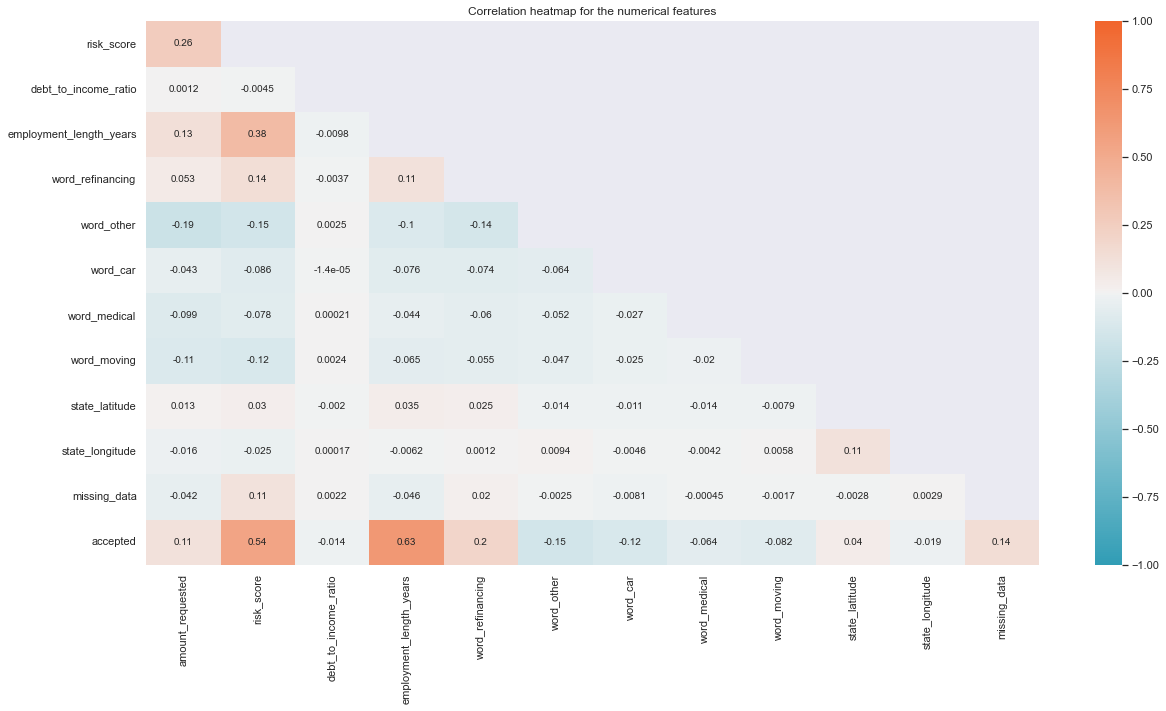

In [ ]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(cleaned_train_set.join(train_accepted).corr(), dtype=bool))
mask = mask[1:, :-1]
corr = cleaned_train_set.join(train_accepted).corr().iloc[1:, :-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

Checking the correlations between features, we can see that debt_to_income_ratio does not have any relevant correlations we could use, so we will use median value. For the other two columns the greatest correlation, excluding the target column, is with each other. Let's take a closer look at them!

In [ ]:
cleaned_train_set.groupby("employment_length_years")["risk_score"].mean()

employment_length_years
0.0     629.851196
1.0     692.005371
2.0     695.772278
3.0     696.698730
4.0     697.252380
5.0     688.215088
6.0     698.583130
7.0     699.000244
8.0     699.400940
9.0     699.647278
15.0    700.991516
Name: risk_score, dtype: float32

Looking at the mean risk_score values for each employment_length_years value, we can see that the means are all almost identical except for the value "0".

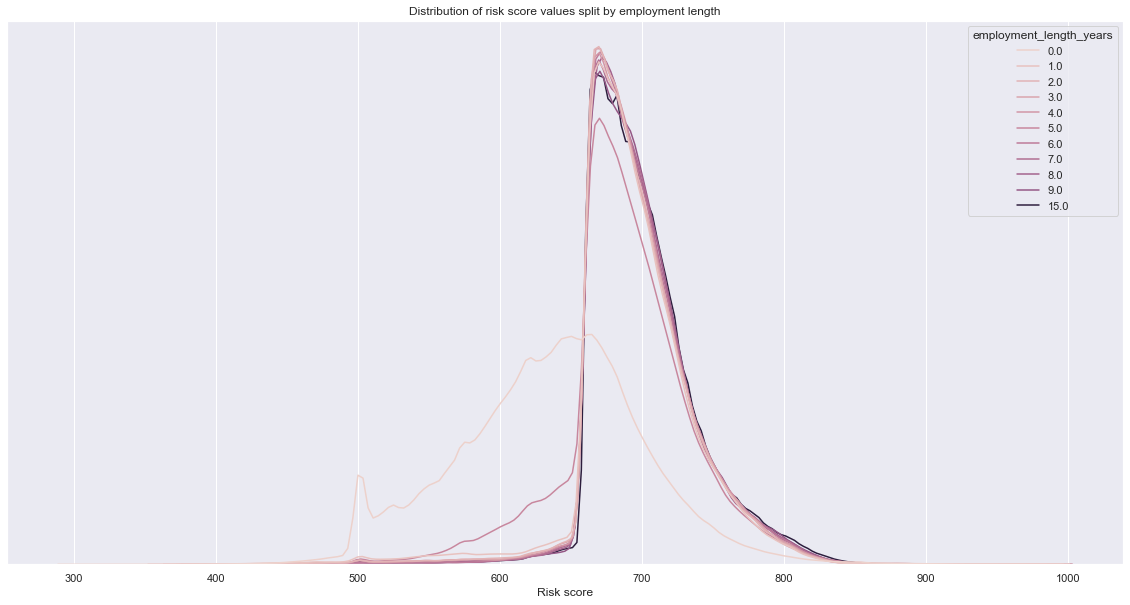

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=cleaned_train_set.join(train_accepted),
    x="risk_score",
    hue="employment_length_years",
    common_norm=False,
)
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distribution of risk score values split by employment length")
ax.set_yticks([])

plt.show()

And if we look at the risk_score plotted, split by employement_length_years, we can see that the distribution is almost identical for values 1 to 15. Only the distribution for value 0 is different. However, since all the missing values come from the accepted dataset, and since as we previously saw, accepted applications are unlikely to have an employment_length_years value of 0, this correlation doesn't really help us for the missing values in employment_length_years column. Since the employment_length_years seems to be a critical column for target prediction, I decided to get rid of the missing data to not muddy the feature.

In [ ]:
train_set = train_set.drop(
    train_set.loc[train_set["employment_length_years"].isna()].index
)
test_set = test_set.drop(test_set.loc[test_set["employment_length_years"].isna()].index)

In [ ]:
print(f'mean | {cleaned_train_set["debt_to_income_ratio"].mean()}')
print(f'median | {cleaned_train_set["debt_to_income_ratio"].median()}')

mean | 95.75413513183594
median | 18.65999984741211


For the debt_to_income_ratio we'll be using median instead of mean because the column is quite heavily skewed.

In [ ]:
train_set.describe().apply(lambda s: s.apply("{0:.5f}".format))

,amount_requested,risk_score,debt_to_income_ratio,employment_length_years
count,3392126.00000,3392126.00000,3390813.00000,3291501.00000
mean,13738.26144,662.46008,95.66722,3.85430
std,10207.52864,78.73376,4249.15527,5.60120
min,150.00000,0.00000,-1.00000,0.00000
25%,5000.00000,632.00000,10.70000,0.00000
50%,10000.00000,672.00000,18.65000,0.00000
75%,20000.00000,702.00000,28.66000,6.00000
max,500000.00000,990.00000,3967200.00000,15.00000


We can see that the "amount_requested" is also skewed. We'll convert both of these features into log scale.

In [ ]:
to_log_list = ["debt_to_income_ratio", "amount_requested"]
preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        ("add_missing_column", AddMissingColumn(missing_dict, one_column=True)),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list)),
    ]
)

full_pipe = Pipeline([("preprocessor", preprocessor)])

cleaned_train_set = full_pipe.fit_transform(train_set)

In [ ]:
cleaned_train_set.isna().sum()

risk_score                  0
employment_length_years     0
word_refinancing            0
word_other                  0
word_car                    0
word_medical                0
word_moving                 0
state_latitude              0
state_longitude             0
missing_data                0
debt_to_income_ratio_log    0
amount_requested_log        0
dtype: int64

All of the missing values are gone.

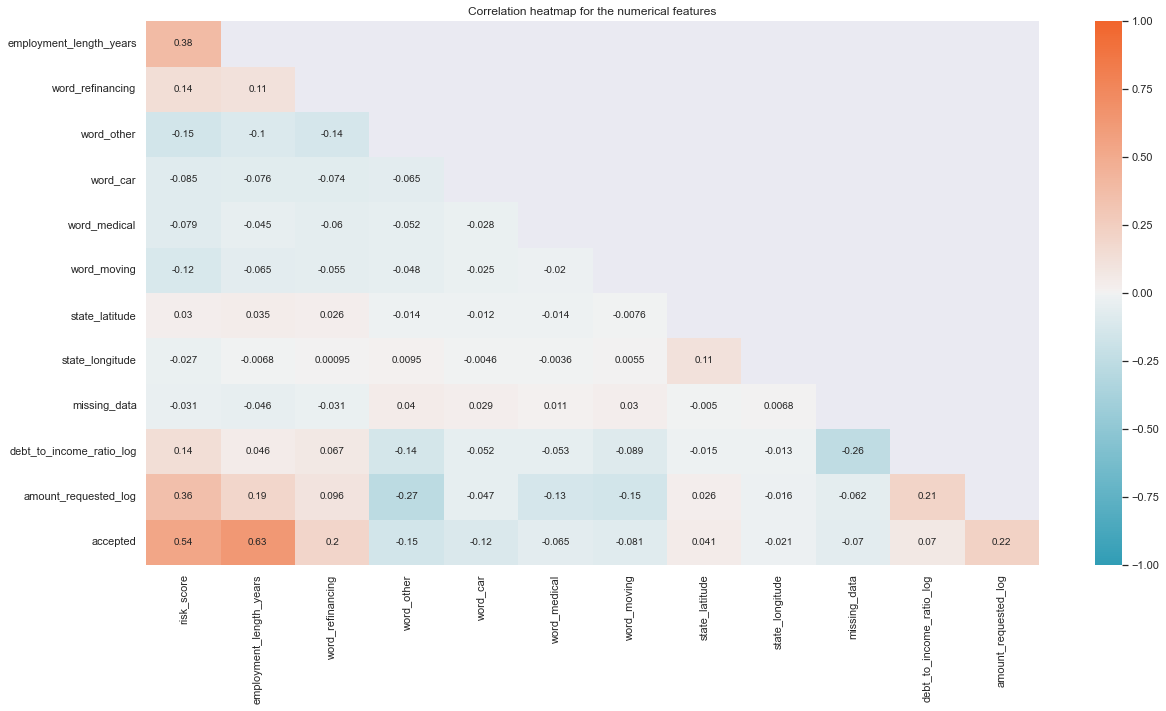

In [ ]:
cmap = sns.diverging_palette(217, 22, 90, 60, as_cmap=True)
mask = np.triu(np.ones_like(cleaned_train_set.join(train_accepted).corr(), dtype=bool))
mask = mask[1:, :-1]
corr = cleaned_train_set.join(train_accepted).corr().iloc[1:, :-1].copy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(corr, cmap=cmap, mask=mask, annot=True, vmin=-1, vmax=1)
ax.set_title("Correlation heatmap for the numerical features")
plt.show()

In the correlation heatmap we can see that both of the features we transformed into log scale now have a better correlation with "accepted" column than they did previously. Let's get to training!

## Model training

In [ ]:
df2 = df.copy()
df = df2.sample(frac=0.1)

df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
df = df.drop(df.loc[df["employment_length_years"].isna()].index)
df = df[df["accepted"] != 2]

We'll be using a sample of the dataset for tuning to speed up the process.

In [ ]:
train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"],
)

In [ ]:
relevant_words = get_relevant_words(train_set, train_accepted)

models = [
    ["svm_rbf", SVC()],
    ["k_neighbors", KNeighborsClassifier()],
    ["logistic_reg", LogisticRegression()],
    ["decision_tree", DecisionTreeClassifier()],
    ["random_forest", RandomForestClassifier()],
    ["boosted_model", GradientBoostingClassifier()],
]

model_scores = pd.DataFrame(
    columns=["f1_score", "recall", "precision", "roc_auc", "model", "fit_time"]
)
missing_dict = {"debt_to_income_ratio": -1, "risk_score": 0}
to_log_list = ["debt_to_income_ratio", "amount_requested"]

for model in models:

    preprocessor = Pipeline(
        [
            ("extract_words", ExtractWords(relevant_words)),
            (
                "zip_to_coords",
                ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
            ),
            ("unknown_to_nan", UnknownToNan(missing_dict)),
            (
                "add_missing_column",
                AddMissingColumn(list(missing_dict.keys()), one_column=True),
            ),
            ("fill_missing_data", FillMissingData()),
            ("transform_to_log", TransformToLog(to_log_list)),
        ]
    )

    full_pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("scaler", MinMaxScaler()),
            (model[0], model[1]),
        ]
    )

    temp = cross_validate(
        full_pipe,
        train_set,
        train_accepted,
        cv=5,
        scoring=("f1", "recall", "precision", "roc_auc"),
    )
    model_scores.loc["default_" + model[0]] = [
        temp["test_f1"].mean(),
        temp["test_recall"].mean(),
        temp["test_precision"].mean(),
        temp["test_roc_auc"].mean(),
        model[0],
        temp["fit_time"].mean(),
    ]

In [ ]:
model_scores

,f1_score,recall,precision,roc_auc,model,fit_time
default_svm_rbf,0.896688,0.892130,0.901303,0.953908,svm_rbf,14.663200
default_k_neighbors,0.899094,0.909580,0.888863,0.946613,k_neighbors,0.407798
default_logistic_reg,0.835901,0.806966,0.867039,0.938660,logistic_reg,0.401399
default_decision_tree,0.913708,0.913220,0.914217,0.921452,decision_tree,0.390797
default_random_forest,0.931609,0.941247,0.922175,0.979457,random_forest,2.843797
default_boosted_model,0.934827,0.936531,0.933139,0.986085,boosted_model,3.016000


The scores for all of the models are quite high, maybe even too high. Let's use shap to check whether there hasn't been any data leakage.

In [ ]:
shap.initjs()

In [ ]:
preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        (
            "add_missing_column",
            AddMissingColumn(list(missing_dict.keys()), one_column=True),
        ),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list)),
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("scaler", MinMaxScaler()),
        ("model", LogisticRegression()),
    ]
)

full_pipe.fit(train_set, train_accepted)

In [ ]:
to_log_list = ["debt_to_income_ratio", "amount_requested"]


preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        (
            "add_missing_column",
            AddMissingColumn(list(missing_dict.keys()), one_column=True),
        ),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list)),
    ]
)

transformer = Pipeline([("preprocessor", preprocessor), ("scaler", MinMaxScaler())])

train_shap = transformer.fit_transform(train_set)
test_shap = transformer.transform(test_set)

column_names = transformer.steps[1][1].feature_names_in_

train_shap = pd.DataFrame(train_shap, index=train_set.index, columns=column_names)
test_shap = pd.DataFrame(test_shap, index=test_set.index, columns=column_names)

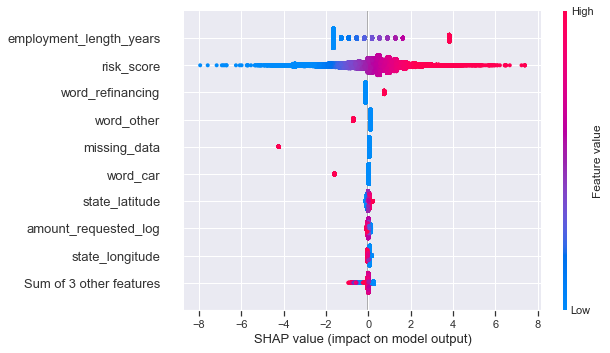

In [ ]:
log_reg = full_pipe[-1]

log_reg.fit(train_shap, train_accepted)
explainer = shap.Explainer(log_reg, train_shap, feature_names=train_shap.columns)
shap_values = explainer(test_shap)

shap.plots.beeswarm(shap_values)

We don't see any features that shouldn't be here. Unsuprisingly, the most important feature is employment length, with risk score as second most important.

We're mostly interested in roc_auc score at the moment and the highest score was for the boosted model. Let's try tuning a XGboost model a bit to see whether we can get an even better score.

In [ ]:
models = {}
accepted_wrapper = lambda trial: objective_booster_class(
    trial, train_set, train_accepted
)
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(accepted_wrapper, n_trials=300)

The best score we get is 0.99556 - can't go much higher than that! Let's see whether the same model is just as good when trained and tested on the full dataset.

In [ ]:
df = df2.copy()

df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
df = df.drop(df.loc[df["employment_length_years"].isna()].index)
df = df[df["accepted"] != 2]

In [ ]:
train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"],
)

[11:50:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




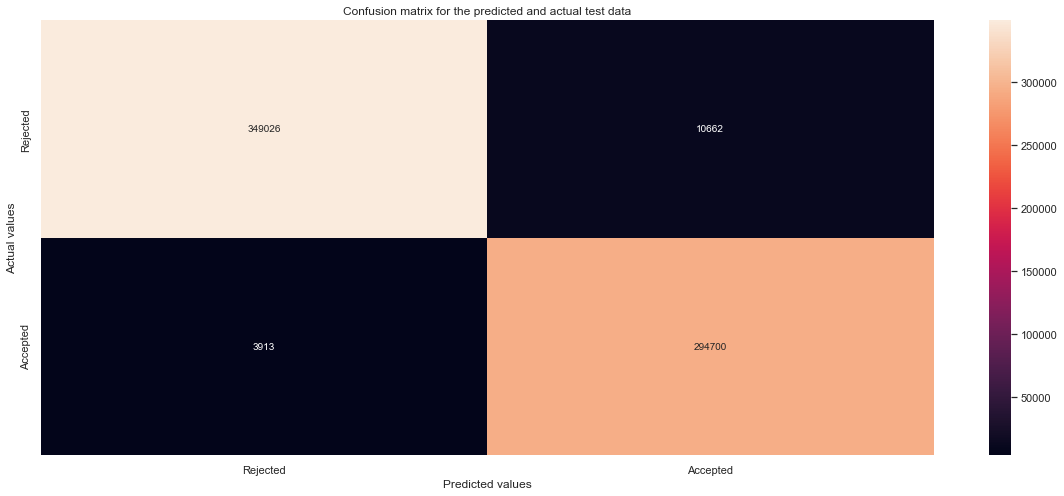

In [ ]:
relevant_words = get_relevant_words(train_set, train_accepted)

preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=False),
        ),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        (
            "add_missing_column",
            AddMissingColumn(list(missing_dict.keys()), one_column=True),
        ),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list)),
    ]
)
full_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("scaler", MinMaxScaler()),
        (
            "model",
            xg.XGBClassifier(
                learning_rate=0.41972,
                n_estimators=246,
                max_depth=3,
                min_impurity_decrease=0.0868,
            ),
        ),
    ]
)

train_set_val, test_set_val, train_accepted_val, test_accepted_val = train_test_split(
    train_set, train_accepted, test_size=0.2, random_state=42, stratify=train_accepted
)

full_pipe.fit(train_set_val, train_accepted_val)

matrix = confusion_matrix(test_accepted_val, full_pipe.predict(test_set_val))
label_list = ["Rejected", "Accepted"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

In [ ]:
roc_auc_score(test_accepted_val, full_pipe.predict(test_set_val))

0.9786268630903732

The score is slightly worse, but not by much. Let's see whether we can't improve it a bit more by changing the threshold.

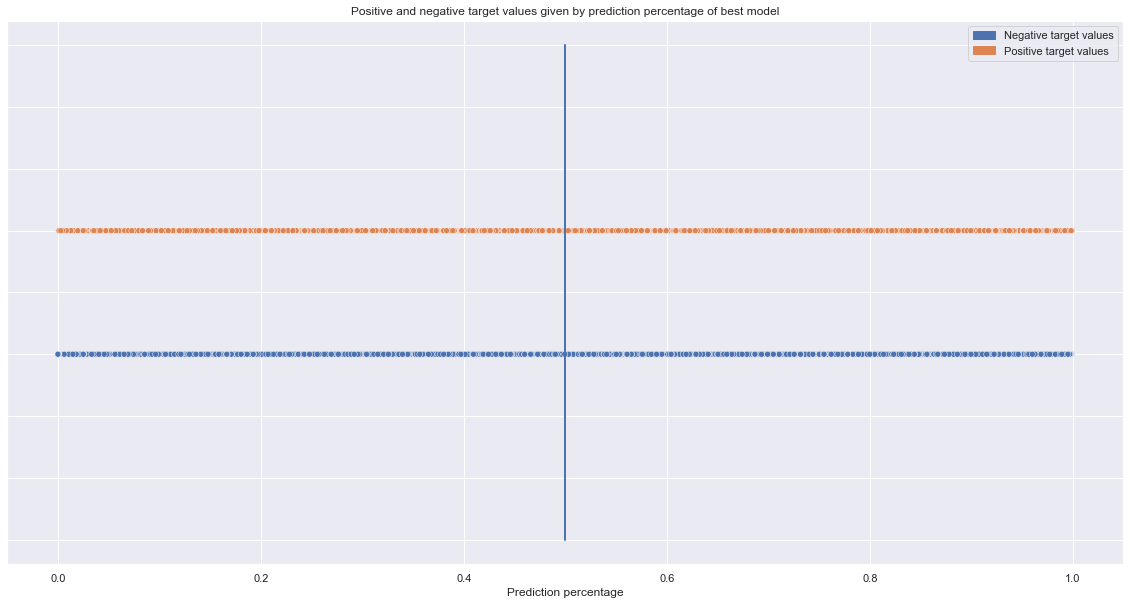

In [ ]:
df_colors = pd.DataFrame()
df_colors["predictions"] = full_pipe.predict_proba(test_set_val)[:, 1]
df_colors["y_numbers"] = np.array(test_accepted_val)
df_colors["loc"] = np.zeros(len(test_accepted_val))
df_colors.loc[df_colors["y_numbers"] == 0, "loc"] -= 0.25
df_colors.loc[df_colors["y_numbers"] == 1, "loc"] += 0.25

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=df_colors, x="predictions", y="loc", hue="y_numbers")

blue_patch = mpatches.Patch(color=colors["blue"], label="Negative target values")
orange_patch = mpatches.Patch(color=colors["orange"], label="Positive target values")
plt.legend(handles=[blue_patch, orange_patch])
ax.set_xlabel("Prediction percentage")
ax.set_ylabel("")
ax.axes.yaxis.set_ticklabels([])
ax.set_title(
    "Positive and negative target values given by prediction percentage of best model"
)
plt.plot([0.5, 0.5], [-1, 1], linewidth=2)
plt.show()

Both positive and negative values are distributed all across the thresholds, so we won't be able to get completely "clean" either of the values.

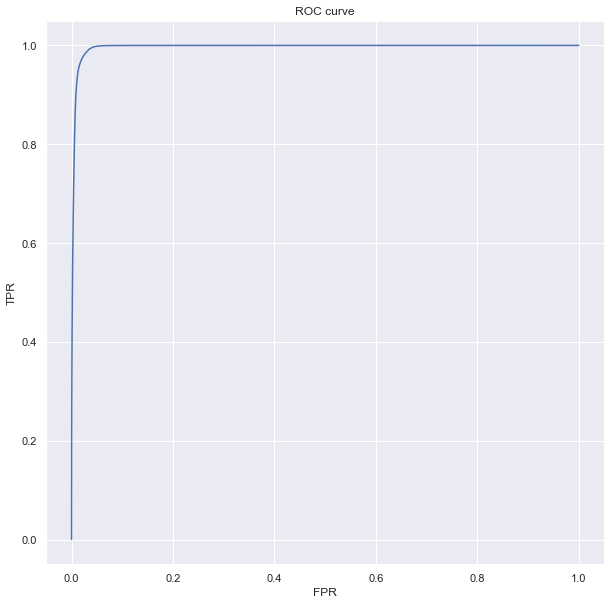

In [ ]:
yhat = full_pipe.predict_proba(test_set_val)
yhat = yhat[:, 1]
fpr, tpr, thresholds = roc_curve(test_accepted_val, yhat)

plt.figure(figsize=(10, 10))
plt.title("ROC curve")
plt.plot(fpr, tpr, "b-")
plt.ylabel("TPR")
plt.xlabel("FPR")
# plt.plot([0.5, 0.5], [-1, 1], linewidth=2)
plt.show()

In [ ]:
best_thresh = sorted(
    list(zip(np.abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True
)[0][1]
best_thresh

0.47115397

Checking the ROC curve, it seems like we can get a slightly better result in correct values, if we move the threshold a bit.
Let's check the model on the test data.

[20:59:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




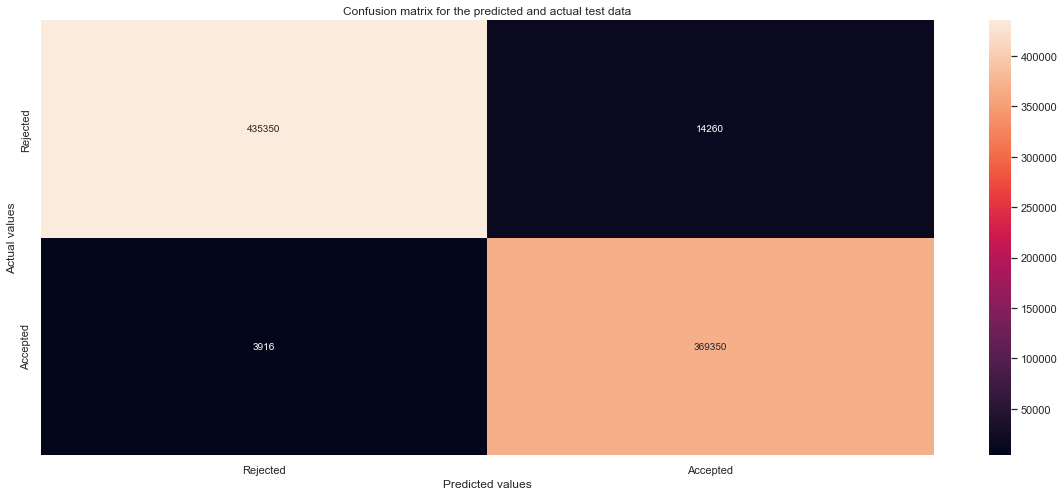

In [ ]:
missing_dict = {"debt_to_income_ratio": -1, "risk_score": 0}
to_log_list = ["debt_to_income_ratio", "amount_requested"]
relevant_words = get_relevant_words(train_set, train_accepted)

preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=False),
        ),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        (
            "add_missing_column",
            AddMissingColumn(list(missing_dict.keys()), one_column=True),
        ),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list)),
    ]
)


full_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("scaler", StandardScaler()),
        (
            "model",
            Thresholder(
                xg.XGBClassifier(
                    learning_rate=0.41972,
                    n_estimators=246,
                    max_depth=3,
                    min_impurity_decrease=0.0868,
                ),
                0.47115397,
            ),
        ),
    ]
)

full_pipe.fit(train_set, train_accepted)

matrix = confusion_matrix(test_accepted, full_pipe.predict(test_set))
label_list = ["Rejected", "Accepted"]

draw_confusion_heatmap(
    matrix,
    [
        "Confusion matrix for the predicted and actual test data",
        "Predicted values",
        "Actual values",
        label_list,
    ],
)

In [ ]:
roc_auc_score(test_accepted, full_pipe.predict(test_set))

0.979181191090564

The score is pretty similar to the one we got with the training data. We'll call it good enough and move to the second task.

In [ ]:
joblib.dump(full_pipe, "models//trained_model_accepted.pkl")

['models//trained_model_accepted.pkl']

## Edit from the future

After completing all the tasks, I started to make an app to house the models. While doing that I happened upon something peculiar -

In [ ]:
model = joblib.load("models//trained_model_accepted.pkl")

In [ ]:
temp_df = pd.DataFrame(columns = ["amount_requested", "loan_title", "risk_score",
    "debt_to_income_ratio", "zip_code", "state", "employment_length_years"])
temp_df.loc[0] = [10000, 'debt consolidation', 733.0, 0, "473", 'AL', 15]
temp_df.loc[1] = [10000, 'debt consolidation', 732.0, 0, "473", 'AL', 15]

In [ ]:
model.predict_proba(temp_df)

array([[0.99524593, 0.00475409],
       [0.21719784, 0.78280216]], dtype=float32)

Even though the two applications differ by only a single risk_score point, the resulting predictions vary wildly.

In [ ]:
df.loc[df["risk_score"] == 733, "accepted"].value_counts()

0    435
Name: accepted, dtype: int64

In [ ]:
df.loc[df["risk_score"] == 732, "accepted"].value_counts()

1    4974
0     371
Name: accepted, dtype: int64

In [ ]:
df.loc[df["accepted"]==1, "risk_score"].value_counts().sort_index(ascending=False).head(10)

847.5     30
842.0     37
837.0     72
832.0    131
827.0    182
822.0    223
817.0    312
812.0    420
807.0    558
802.0    699
Name: risk_score, dtype: int64

If we check the risk scores more closely, we can see that 733 for some reason has no positive values at all and that leads to severe overfitting by the xgboost. The reason for this is that the accepted data did not have a single risk_score value, but instead an upper and lower boundaries 4 or 5 units apart. To transform them into a single feature I decided to take the mean value. Apparently these upper and lower boundaries are discrete not continuous, which led the means also to be discrete.

To mitigate this, we will round the rejected application risk_score values to match the available values from the accepted applications.

In [ ]:
df = df2.sample(frac=0.1)

df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
df = df.drop(df.loc[df["employment_length_years"].isna()].index)
df = df[df["accepted"] != 2]

unique_risk_score = df.loc[df["accepted"]==1, "risk_score"].unique().tolist()
for elem in unique_risk_score:
    df.loc[((df["risk_score"] - 2) < elem) & (elem < (df["risk_score"] + 2)), "risk_score"] = elem

In [ ]:
train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"],
)

In [ ]:
models = {}
accepted_wrapper = lambda trial: objective_booster_class(
    trial, train_set, train_accepted
)
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(accepted_wrapper, n_trials=40)

We'll tune the model again and then train it on the full data

In [ ]:
df = df2.copy()

df = df.drop(df[df["zip_code"].isnull()].index.tolist(), axis=0)
df = df.drop(df.loc[df["employment_length_years"].isna()].index)
df = df[df["accepted"] != 2]

unique_risk_score = df.loc[df["accepted"]==1, "risk_score"].unique().tolist()
for elem in unique_risk_score:
    df.loc[((df["risk_score"] - 2) < elem) & (elem < (df["risk_score"] + 2)), "risk_score"] = elem

In [ ]:
train_set, test_set, train_accepted, test_accepted = train_test_split(
    df.loc[:, df.columns[df.columns != "accepted"]],
    df["accepted"],
    test_size=0.2,
    random_state=42,
    stratify=df["accepted"],
)

In [ ]:
missing_dict = {"debt_to_income_ratio": -1, "risk_score": 0}
to_log_list = ["debt_to_income_ratio", "amount_requested"]
relevant_words = get_relevant_words(train_set, train_accepted)

preprocessor = Pipeline(
    [
        ("extract_words", ExtractWords(relevant_words)),
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        ("unknown_to_nan", UnknownToNan(missing_dict)),
        (
            "add_missing_column",
            AddMissingColumn(list(missing_dict.keys()), one_column=True),
        ),
        ("fill_missing_data", FillMissingData()),
        ("transform_to_log", TransformToLog(to_log_list)),
    ]
)


full_pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("scaler", MinMaxScaler()),
        (
            "model",
            Thresholder(
                xg.XGBClassifier(
                    learning_rate=0.3225,
                    n_estimators=283,
                    max_depth=3,
                    min_impurity_decrease=0.0453,
                ),
                0.47115397,
            ),
        ),
    ]
)

full_pipe.fit(train_set, train_accepted)


In [ ]:
roc_auc_score(test_accepted, full_pipe.predict(test_set))

0.9560622320501394

The model is noticeably worse than before - hopefully that means that it is not overfitting any more.

In [ ]:
joblib.dump(full_pipe, "models//trained_model_accepted.pkl")

['models//trained_model_accepted.pkl']

In [ ]:
del cleaned_train_set
del df
del df2
del train_set

# Second task

## Setting up the data

The dataset we're going to use for the second and third tasks has a lot of columns - around 150. While the principle "More data = more better" still stands, the problem for this dataset is that it's obvious that some of the columns are updated after the loan has been given out, which, if used in model, may provide target data leakage. Due to there being limited info about the dataset and the features, it's not easy to check which features were made at the application origination and which have been updated after. To check, we will load a different version of the same dataset, from a different year, check for same loan ids and then see which features have changed and which have not.

In [ ]:
df = pd.read_csv("data/Loan_status_2007-2020Q3.gzip")
df_2 = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925493 entries, 0 to 2925492
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(1), object(35)
memory usage: 3.1+ GB


In [ ]:
df_2 = df_2.loc[df_2["id"].isin(df["id"])]
df = df.loc[df["id"].isin(df_2["id"])]

df = df.loc[df["id"].astype("str").str.isnumeric()]
df_2 = df_2.loc[df_2["id"].astype("str").str.isnumeric()]

df_2 = df_2.set_index("id")
df = df.set_index("id")

df.index = df.index.astype(int)
df_2.index = df_2.index.astype(int)

df = df.sort_index()
df_2 = df_2.sort_index()

In [ ]:
original_columns = []
changed_columns = []
not_found_columns = []
for column in df_2.columns:
    if column in df.columns:
        if not df_2[column].dtype == df[column].dtype:
            df[column] = df[column].str.strip("%").astype("float")
        if df_2[column].equals(df[column]):
            original_columns.append(column)
        else:
            changed_columns.append(column)
    else:
        not_found_columns.append(column)

We sorted the feature names in three lists - columns that have not changed since origination, columns that did and columns that were missing in the second dataset.

Now that we know which features are relevant to us, we can go on to EDA.


In [ ]:
del df
del df_2

## EDA

We will not be using the changed_columns at all, but it might be worth it to check the columns in the not_found_columns list.

In [ ]:
df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


In [ ]:
pd.set_option("display.max_colwidth", None)

In [ ]:
titles = pd.read_excel("LCDataDictionary.xlsx")
titles = pd.DataFrame(titles.set_index("LoanStatNew").T)
titles = titles.loc[:, titles.columns[:-2]]

In [ ]:
df.head().append(titles).loc[:, not_found_columns]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,member_id,desc,sec_app_mths_since_last_major_derog,disbursement_method,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,NaN,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Cash,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,Cash,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Cash,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Cash,NaN,NaN,NaN,NaN,NaN,NaN
Description,A unique LC assigned Id for the borrower member.,Loan description provided by the borrower,NaN,"The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY",The most recent date that the Debt_Settlement_Flag has been set,"The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT",The date that the borrower agrees to the settlement plan,The loan amount that the borrower has agreed to settle for,The settlement amount as a percentage of the payoff balance amount on the loan,The number of months that the borrower will be on the settlement plan


In [ ]:
df.loc[:, not_found_columns].isnull().sum() * 100 / df.shape[0]

member_id                              100.000000
desc                                    94.423544
sec_app_mths_since_last_major_derog     98.410139
disbursement_method                      0.001460
debt_settlement_flag_date               98.485160
settlement_status                       98.485160
settlement_date                         98.485160
settlement_amount                       98.485160
settlement_percentage                   98.485160
settlement_term                         98.485160
dtype: float64

Most of the features in the list have almost all of their data missing. Two columns seem to be of interest to us - desc and disbursement_method. Both seem to have been created at the origination of the loan. However, the desc column has too much missing data, and since it is text data, it would probably require quite extensive data engineering to be useful, so we won't be using it after all.

In [ ]:
df = df.loc[:, original_columns + ["disbursement_method"]]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 105 entries, loan_amnt to disbursement_method
dtypes: float64(86), object(19)
memory usage: 1.8+ GB


After getting rid of changed and missing columns, we have dropped a third of the total feature count. Before we get on with the EDA, let's check whether there are any more columns that should be dropped.

Let's start by checking the missing data.

In [ ]:
missing_percentage = df.loc[:, original_columns].isnull().sum() * 100 / df.shape[0]
missing_percentage[missing_percentage > 40].sort_values()

mths_since_rcnt_il                    40.251099
il_util                               47.281042
mths_since_last_delinq                51.246715
mths_since_recent_revol_delinq        67.250910
mths_since_last_major_derog           74.309960
mths_since_recent_bc_dlq              77.011511
mths_since_last_record                84.113069
annual_inc_joint                      94.660506
dti_joint                             94.660683
verification_status_joint             94.880791
sec_app_num_rev_accts                 95.221792
sec_app_open_act_il                   95.221792
sec_app_open_acc                      95.221792
sec_app_mort_acc                      95.221792
sec_app_collections_12_mths_ex_med    95.221792
sec_app_earliest_cr_line              95.221792
sec_app_fico_range_high               95.221792
sec_app_fico_range_low                95.221792
sec_app_chargeoff_within_12_mths      95.221792
sec_app_inq_last_6mths                95.221792
revol_bal_joint                       95

We can see that all of the columns with most missing data have to do with secondary and joint accounts.

In [ ]:
df["application_type"].value_counts() * 100 / df.shape[0]

Individual    94.659046
Joint App      5.339494
Name: application_type, dtype: float64

Checking the split between individual and joint apps, we can see that the proportion of existing data for secondary and joint columns almost precisely matches the proportion of joint apps.

Taking the mean value for features between primary and secondary accounts might be a good idea to get rid of the secondary and joint columns.

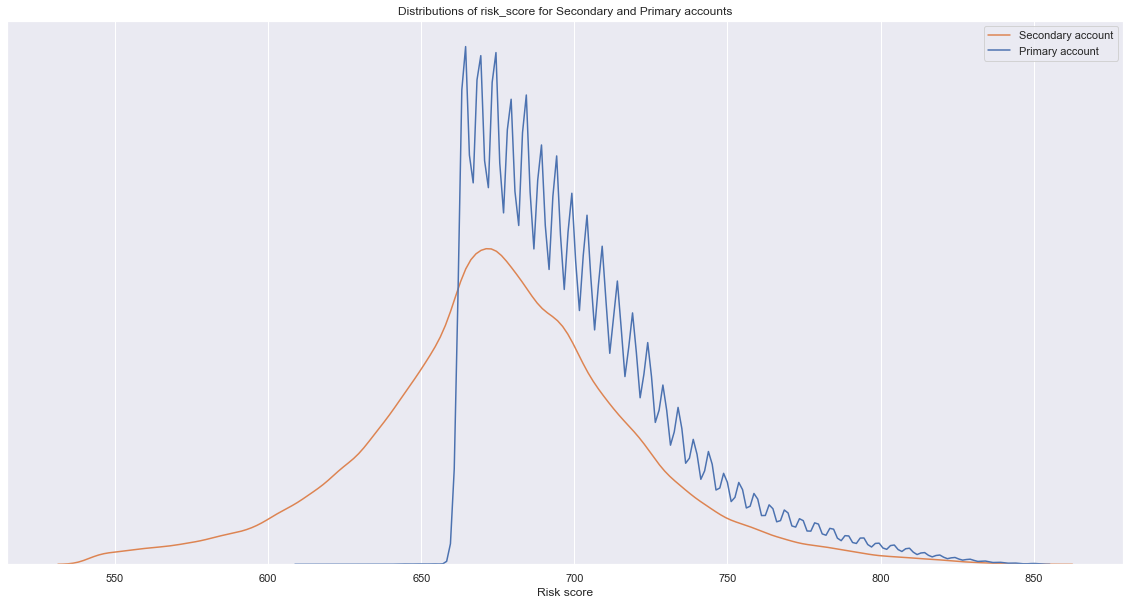

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    x=df["sec_app_fico_range_high"].fillna(df["fico_range_high"]),
    hue=df["application_type"],
    common_norm=False,
)
plt.legend(labels=["Secondary account", "Primary account"], title="")
ax.set(xlabel="Risk score", ylabel="")
ax.set_title("Distributions of risk_score for Secondary and Primary accounts")
ax.set_yticks([])

plt.show()

However if we look at the risk_score distributions for primary and secondary accounts, we can see that the distributions of values are different - for example a value below 650 is impossible for primary account, but possible for secondary. If we took the mean values, we might change the distributions of the more important primary features.

A good way to deal with this would be to make a seperate model for joint applications. For now we will drop the secondary and joint columns.

In [ ]:
top_value_percentage = (
    df.loc[:, df.columns[~(df.dtypes == "string")]].apply(
        lambda x: x.value_counts().max(), axis=0
    )
    * 100
    / df.shape[0]
)
top_value_percentage[top_value_percentage > 50].sort_values()

title                         51.014840
purpose                       56.525697
inq_last_6mths                61.119184
initial_list_status           67.919950
term                          71.205967
num_accts_ever_120_pd         74.641273
delinq_2yrs                   81.351227
tot_coll_amt                  82.104135
pub_rec                       84.166725
pub_rec_bankruptcies          87.910033
num_tl_90g_dpd_24m            91.699875
num_tl_120dpd_2m              93.145356
application_type              94.659046
disbursement_method           96.542886
num_tl_30dpd                  96.632018
tax_liens                     97.135048
collections_12_mths_ex_med    98.336091
chargeoff_within_12_mths      99.232008
acc_now_delinq                99.608794
delinq_amnt                   99.679922
policy_code                   99.998540
dtype: float64

If we check the variability for the features, we can see that there are several features that are almost completely filled with a single value. We will be dropping all that have less than 2% comprised of other values.

In [ ]:
df.isnull().sum().sort_values().head()

loan_amnt              33
disbursement_method    33
application_type       33
policy_code            33
initial_list_status    33
dtype: int64

In [ ]:
df.isna().all(axis=1).sum()

33

There are also some rows that are completely empty - we'll be getting rid of those.

In [ ]:
(df["fico_range_high"] - df["fico_range_low"]).value_counts()

4.0    2260227
5.0        441
dtype: int64

And finally we will combine fico_range_low and fico_range_high into risk_score column

In [ ]:
df = clean_data_2_1(df)

Besides dropping the unnecesarry columns, we will also clean up the data - change columns that should be numeric, but contain non-numeric characters into purely numeric, change a column containing date, into column containing months since the date, convert grade and subgrade columns into numeric.

Also, we will check whether any columns are too closely correlated and if they are, after calculating their correlation with the target column, drop one and leave the other.

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
titles = titles.rename(
    columns={
        "earliest_cr_line": "mths_since_earliest_cr_line",
        "emp_length": "emp_length_years",
        "addr_state": "state",
        "fico_range_high": "risk_score",
    }
)
titles = titles.drop(titles.columns[~titles.columns.isin(df.columns)], axis=1)
titles["risk_score"] = "Borrower’s FICO at loan origination."
df.head().append(titles)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,loan_amnt,term,grade,sub_grade,emp_title,emp_length_years,home_ownership,annual_inc,verification_status,issue_d,purpose,zip_code,state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,initial_list_status,application_type,tot_coll_amt,open_act_il,open_il_12m,mths_since_rcnt_il,total_bal_il,il_util,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_tl,num_il_tl,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,disbursement_method,risk_score
0,3600,36 months,3,21,leadman,15,mortgage,55000.0,Not Verified,2015-12-01 00:00:00,debt_consolidation,190xx,PA,5.91,0,1,30,NaN,0,w,Individual,722,2,0,21,4981,36,722,34,3,1,4,1506,37.200001,148,128,3,3,1,4,4,2,4,5,3,7,0,0,0,3,76.900002,0,0,178050,Cash,677.0
1,24700,36 months,3,24,Engineer,15,mortgage,65000.0,Not Verified,2015-12-01 00:00:00,small_business,577xx,SD,16.059999,1,4,6,NaN,0,w,Individual,0,1,0,19,18005,73,6472,29,0,0,6,57830,27.1,113,192,2,2,4,2,0,0,5,17,6,22,0,0,0,2,97.400002,0,0,314017,Cash,717.0
2,20000,60 months,2,26,truck driver,15,mortgage,63000.0,Not Verified,2015-12-01 00:00:00,home_improvement,605xx,IL,10.78,0,0,<NA>,NaN,0,w,Joint App,0,1,0,19,10827,73,2081,65,2,5,1,2737,55.900002,125,184,14,14,5,101,10,0,3,4,6,6,0,0,0,0,100.0,0,0,218418,Cash,697.0
3,35000,60 months,3,20,Information Systems Officer,15,mortgage,110000.0,Source Verified,2015-12-01 00:00:00,debt_consolidation,076xx,NJ,17.059999,0,0,<NA>,NaN,0,w,Individual,0,1,0,23,12609,70,6987,45,0,1,0,54962,12.1,36,87,2,2,1,2,<NA>,0,5,10,2,13,0,0,0,1,100.0,0,0,381215,Cash,787.0
4,10400,60 months,6,9,Contract Specialist,3,mortgage,104433.0,Source Verified,2015-12-01 00:00:00,major_purchase,174xx,PA,25.370001,1,3,12,NaN,0,w,Individual,0,3,0,14,73839,84,9702,78,2,1,3,4567,77.5,128,210,4,4,6,4,1,0,6,9,10,12,0,0,0,4,96.599998,0,0,439570,Cash,697.0
Description,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",The number of payments on the loan. Values are in months and can be either 36 or 60.,LC assigned loan grade,LC assigned loan subgrade,The job title supplied by the Borrower when applying for the loan.*,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER",The self-reported annual income provided by the borrower during registration.,"Indicates if income was verified by LC, not verified, or if the income source was verified",The month which the loan was funded,A category provided by the borrower for the loan request.,The first 3 numbers of the zip code provided by the borrower in the loan application.,The state provided by the borrower in the loan application,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.",The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years,The number of inquiries in past 6 months (excluding auto and mortgage inquiries),The number of months since the borrower's last delinquency.,The number of months since the last public record.,Number of derogatory public records,"The initial listing status of the loan. Possible values are – W, F",Indicates whether the loan is an individual application or a joint application with two co-borrowers,Total collection amounts ever owed,Number of currently active installment trades,Number of installment account

Let's get on with the EDA now. First let's try to get a overall view of the data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2260668 entries, 0 to 2260698
Data columns (total 56 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   loan_amnt               Int32         
 1   term                    string        
 2   grade                   Int8          
 3   sub_grade               Int8          
 4   emp_title               string        
 5   emp_length_years        Int8          
 6   home_ownership          string        
 7   annual_inc              Float32       
 8   verification_status     string        
 9   issue_d                 datetime64[ns]
 10  purpose                 string        
 11  zip_code                string        
 12  state                   string        
 13  dti                     Float32       
 14  delinq_2yrs             Int8          
 15  inq_last_6mths          Int8          
 16  mths_since_last_delinq  Int16         
 17  mths_since_last_record  Int16         
 18  pu

In [ ]:
missing_percentage = df.isnull().sum() * 100 / df.shape[0]
missing_percentage[missing_percentage > 30].sort_values()

open_act_il                       38.312968
open_il_12m                       38.312968
open_il_24m                       38.312968
total_bal_il                      38.312968
inq_fi                            38.312968
open_rv_12m                       38.312968
open_rv_24m                       38.312968
max_bal_bc                        38.312968
inq_last_12m                      38.313012
total_cu_tl                       38.313012
open_acc_6m                       38.313012
all_util                          38.322655
mths_since_rcnt_il                40.250227
il_util                           47.280273
mths_since_last_delinq            51.246003
mths_since_recent_revol_delinq    67.250432
mths_since_last_major_derog       74.309585
mths_since_recent_bc_dlq          77.011175
mths_since_last_record            84.112837
dtype: float64

There are still features with a lot of values missing, but we'll deal with those later in data engineering part.

In [ ]:
df.loc[:, df.columns[df.dtypes == "string"]].nunique()

term                        2
emp_title              512694
home_ownership              6
verification_status         3
purpose                    14
zip_code                  956
state                      51
initial_list_status         2
application_type            2
disbursement_method         2
dtype: int64

Among categorical features 4 are binary and 3 others have unique values below 20. Then there are "state" and "zip_code" features which we will convert into coordinates similarly as we did for the previous task. Finally the emp_title has a large amount of different values.

In [ ]:
df["grade"].value_counts()

2    663557
3    650053
1    433027
4    324424
5    135639
6     41800
7     12168
Name: grade, dtype: Int64

In [ ]:
(df.groupby("grade")["sub_grade"].nunique() == 5).all()

True

We have transformed grades into numbers with A as 1 and G as 7. We can see that there are more applications for better grades than there are for the worse ones. Also, each of the subgrades have at least one application asssigned.

Now let's check the categorical feature distribution across grades and subgrades. I will only show the features that have a reasonable difference in distribution between the values. Also, to be more intuitive, I inverted the subgrade values - the higher the number, the better the grade.

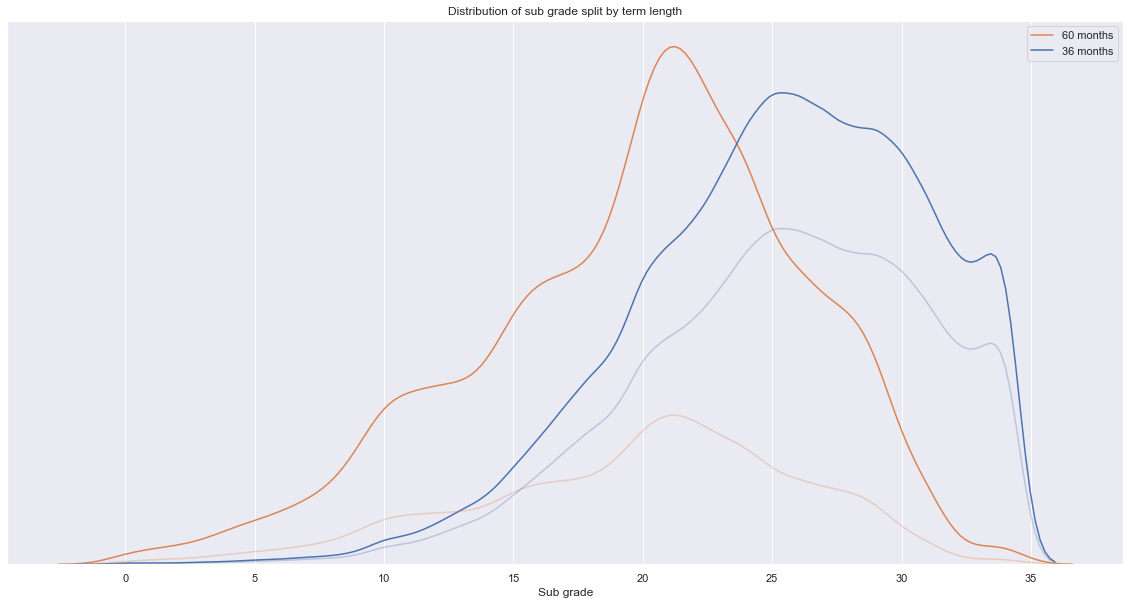

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="term",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    common_norm=False,
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="term",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    alpha=0.3,
)
ax.set(xlabel="Sub grade", ylabel="")
ax.legend(labels=["60 months", "36 months"], title="")
ax.set_title("Distribution of sub grade split by term length")
ax.set_yticks([])
plt.show()

People taking loans with longer term length tend to get worse grades.

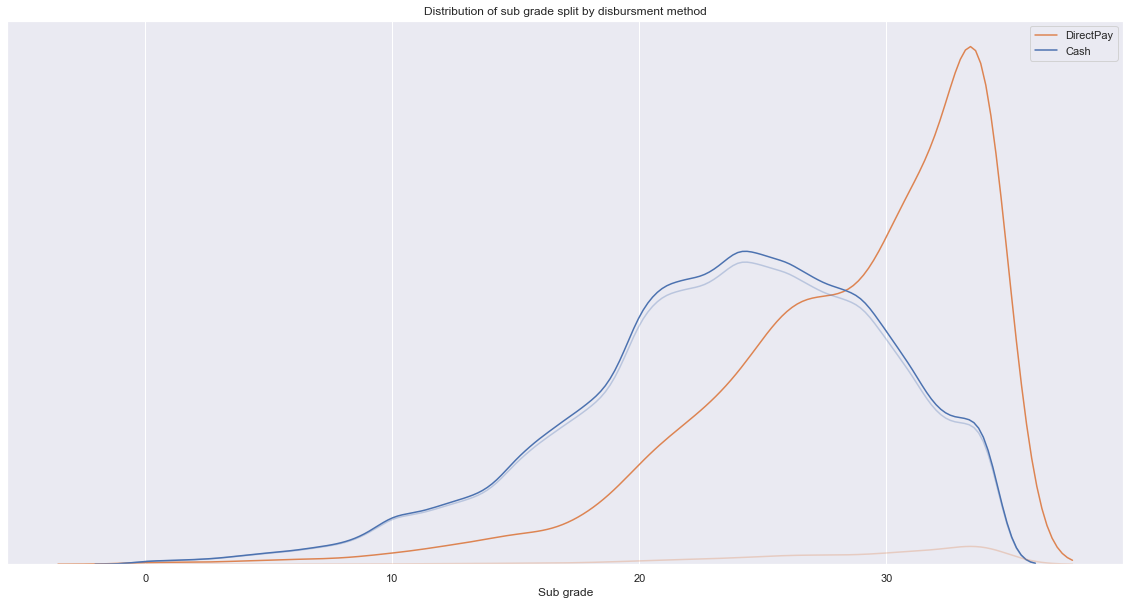

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="disbursement_method",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    common_norm=False,
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="disbursement_method",
    palette=[colors["blue"], colors["orange"]],
    bw_adjust=2,
    alpha=0.3,
)
ax.set(xlabel="Sub grade", ylabel="")
ax.legend(labels=["DirectPay", "Cash"], title="")
ax.set_title("Distribution of sub grade split by disbursment method")
ax.set_yticks([])
plt.show()

While there is only a small fraction of people choosing DirectPay disbusement method, they are almost exclusively ones that received highest grades.

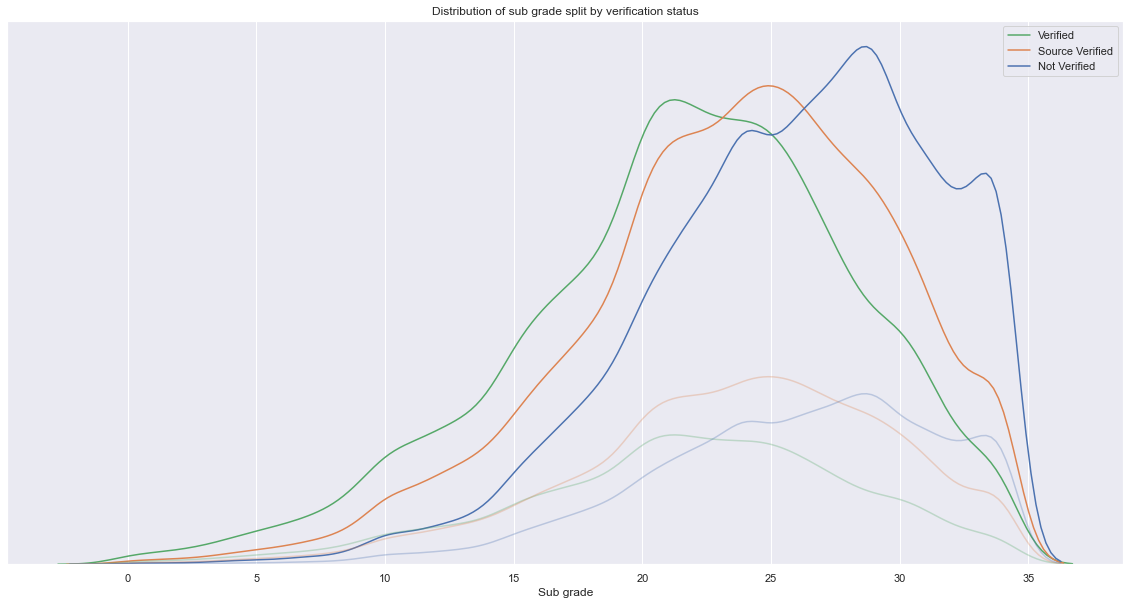

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="verification_status",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    common_norm=False,
)
ax = sns.kdeplot(
    data=df,
    x="sub_grade",
    hue="verification_status",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    alpha=0.3,
)

ax.set(xlabel="Sub grade", ylabel="")
ax.legend(labels=["Verified", "Source Verified", "Not Verified"], title="")
ax.set_title("Distribution of sub grade split by verification status")
ax.set_yticks([])
plt.show()

Verification status seem to have an impact on the grade. However, suprisingly, applicants with unverified income seem to get higher grades. It might also be that due to having a better overall financial state, which gives them a better grade also allows the loan company to take the applicants on their word and not check their income.

In [ ]:
df["purpose"].value_counts() * 100 / df.shape[0]

debt_consolidation    56.526522
credit_card           22.868064
home_improvement       6.655422
other                  6.168088
major_purchase          2.23142
medical                1.215924
small_business         1.092111
car                    1.062208
vacation               0.686744
moving                 0.681347
house                  0.625302
wedding                0.104173
renewable_energy       0.063919
educational            0.018756
Name: purpose, dtype: Float64

While the purpose feature has a lot of different values, most of them are only a small fraction of the total count. We will be taking a closer look on only 4 largest percentage values.

In [ ]:
largest_purposes = (
    df["purpose"]
    .value_counts()[(df["purpose"].value_counts() * 100 / df.shape[0]) > 5]
    .index
)
temp_df = df.loc[df["purpose"].isin(largest_purposes), ["purpose", "sub_grade"]]

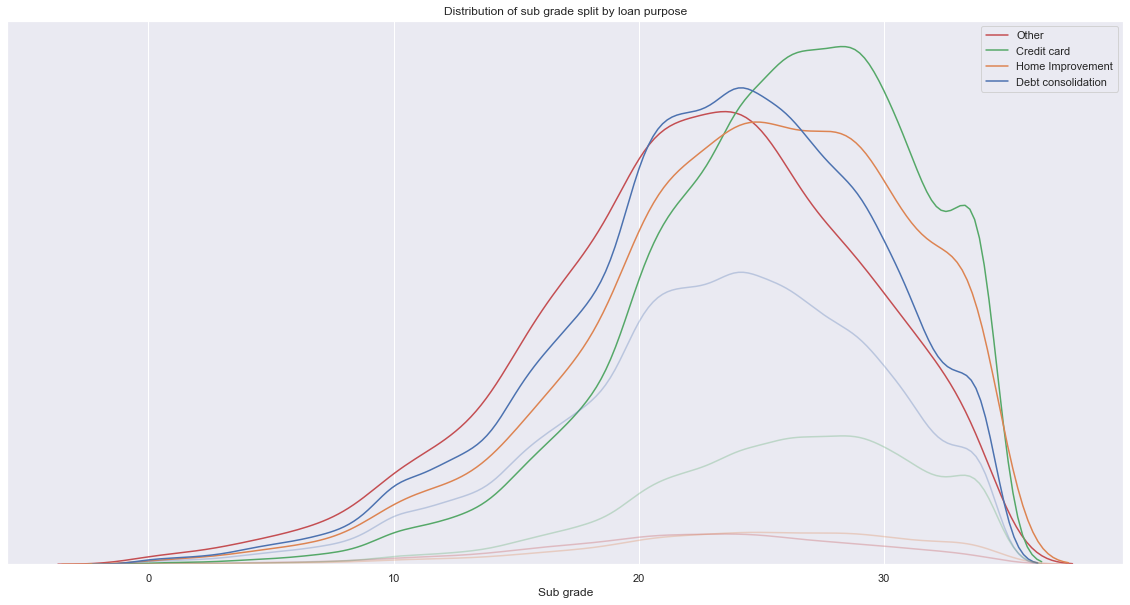

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="purpose",
    palette=[colors["blue"], colors["orange"], colors["green"], colors["red"]],
    bw_adjust=2,
    common_norm=False,
)
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="purpose",
    palette=[colors["blue"], colors["orange"], colors["green"], colors["red"]],
    bw_adjust=2,
    alpha=0.3,
)
ax.set(xlabel="Sub grade", ylabel="")
ax.legend(
    labels=["Other", "Credit card", "Home Improvement", "Debt consolidation"], title=""
)
ax.set_title("Distribution of sub grade split by loan purpose")
ax.set_yticks([])
plt.show()

Purpose also seems to have little impact on the grade.

In [ ]:
df["home_ownership"].value_counts() * 100 / df.shape[0]

mortgage    48.205712
rent        40.445887
own         11.291016
any          0.046496
other        0.008505
none         0.002383
Name: home_ownership, dtype: float64

In [ ]:
largest_home_ownership = (
    df["home_ownership"]
    .value_counts()[(df["home_ownership"].value_counts() * 100 / df.shape[0]) > 5]
    .index
)
temp_df = df.loc[
    df["home_ownership"].isin(largest_home_ownership), ["home_ownership", "sub_grade"]
]

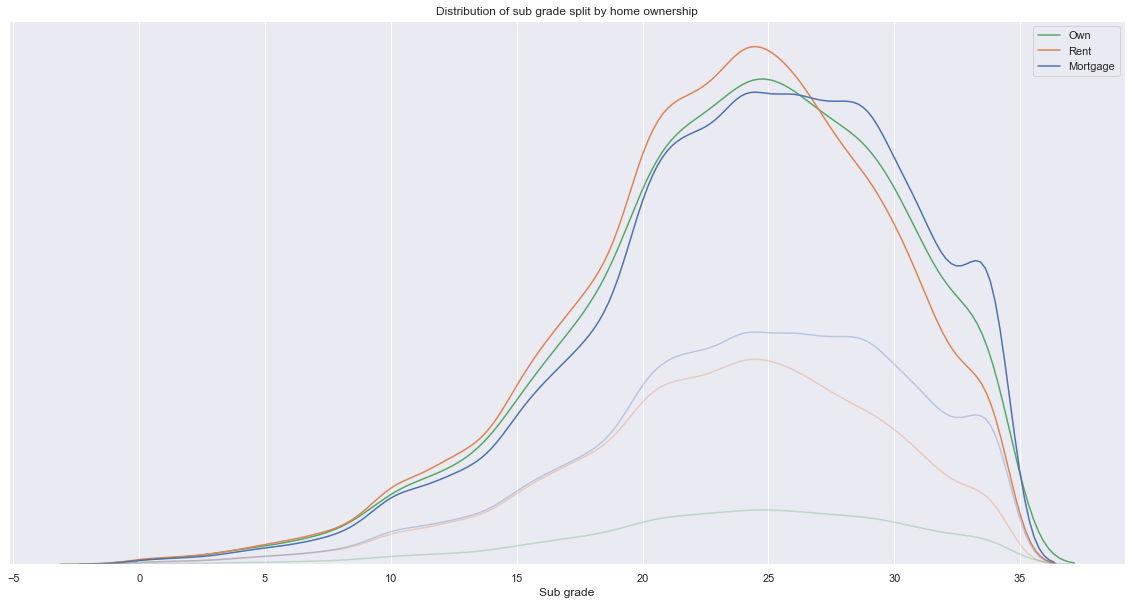

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="home_ownership",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    common_norm=False,
)
ax = sns.kdeplot(
    data=temp_df,
    x="sub_grade",
    hue="home_ownership",
    palette=[colors["blue"], colors["orange"], colors["green"]],
    bw_adjust=2,
    alpha=0.3,
)
ax.set(xlabel="Sub grade", ylabel="")
ax.legend(labels=["Own", "Rent", "Mortgage"], title="")
ax.set_title("Distribution of sub grade split by home ownership")
ax.set_yticks([])
plt.show()

Home ownership also does not seem to be very important.

In [ ]:
df["emp_title"] = df["emp_title"].str.lower().str.replace("[^a-zA-Z0-9 ]", "")
prof_df = (
    pd.Series(
        [
            y
            for x in df["emp_title"]
            .str.lower()
            .str.replace(r"[^a-zA-Z0-9 ]", "")
            .dropna()
            for y in x.split()
        ]
    )
    .value_counts()
    .to_frame("total")
)
prof_df.head()

,total
manager,291503
director,77294
sales,69221
assistant,68137
supervisor,55071


In [ ]:
prof_df.shape[0]

95854

There are almost 100000 different words used in the employee title column. We can see that the amount of times used varies wildly between the different words. We might use this column to see whether usage of a particular career name improves or decreases the loan grade.

Next let's look at the numerical columns. Again, I will be showing only the columns that seem to be most closely related to grade.

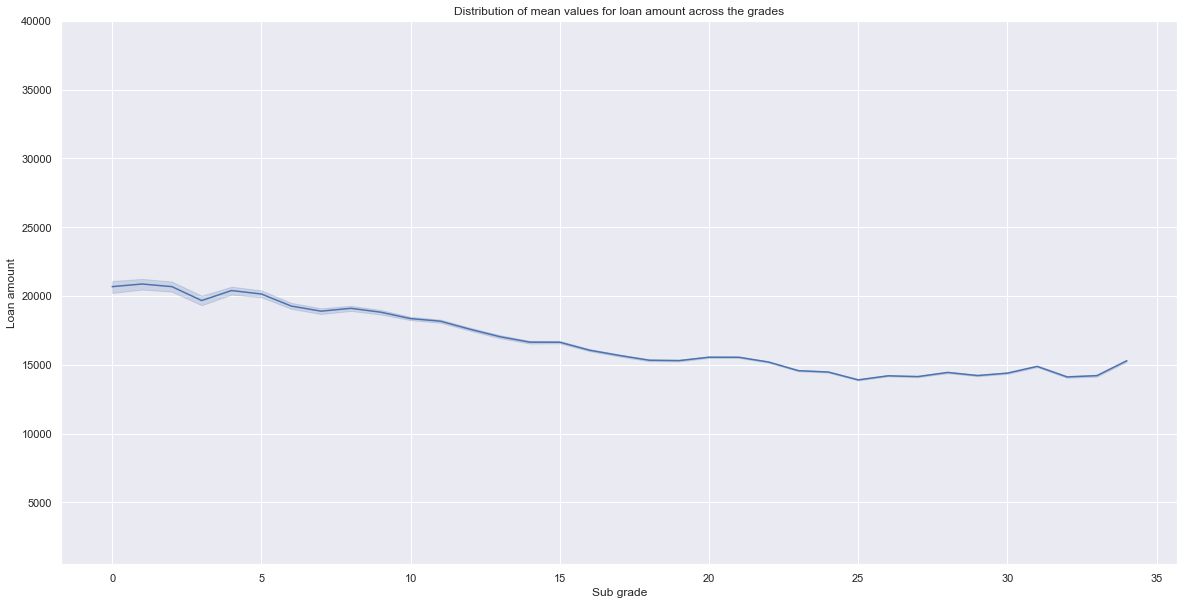

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=df, x="sub_grade", y="loan_amnt", markers=True)
ax.set(xlabel="Sub grade", ylabel="Loan amount")
ax.set_title("Distribution of mean values for loan amount across the grades")
ax.set_ylim([df["loan_amnt"].min(), df["loan_amnt"].max()])
plt.show()

Loans with higher requested amount tend to have a lower grade.

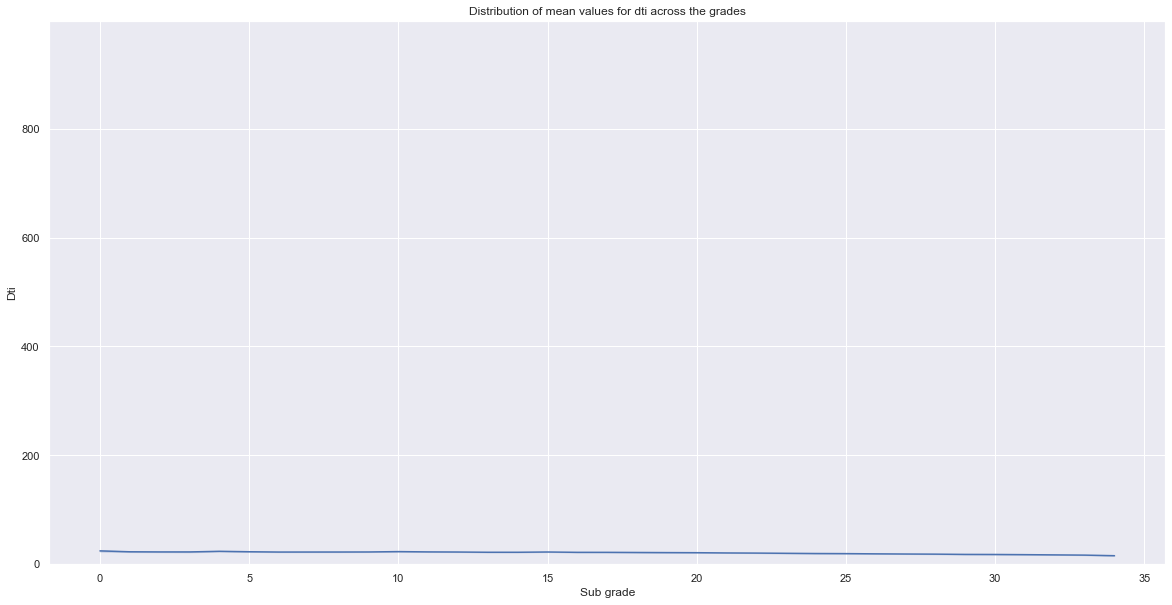

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=df, x="sub_grade", y="dti", markers=True)
ax.set(xlabel="Sub grade", ylabel="Dti")
ax.set_title("Distribution of mean values for dti across the grades")
ax.set_ylim([df["dti"].min(), df["dti"].max()])
plt.show()

Loans with lower dti tend to have a better grade.

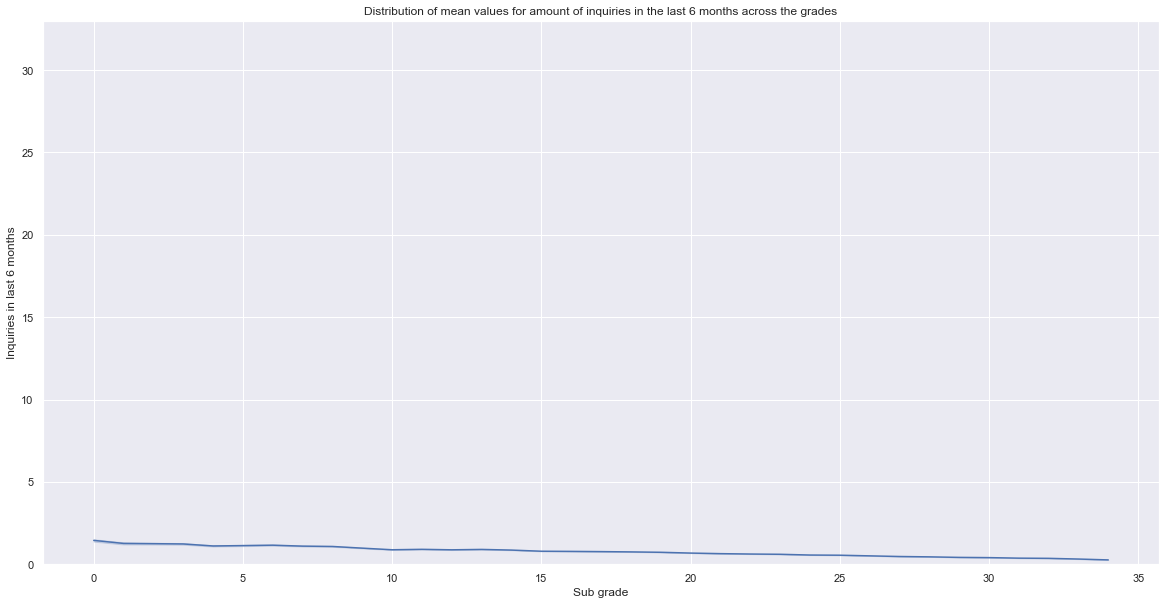

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=df, x="sub_grade", y="inq_last_6mths", markers=True)
ax.set(xlabel="Sub grade", ylabel="Inquiries in last 6 months")
ax.set_title(
    "Distribution of mean values for amount of inquiries in the last 6 months across the grades"
)
ax.set_ylim([df["inq_last_6mths"].min(), df["inq_last_6mths"].max()])
plt.show()

While the amount of inquiries in last 6 months seems to be quite low for all applicants, it tends to be even lower for applications with higher grade.

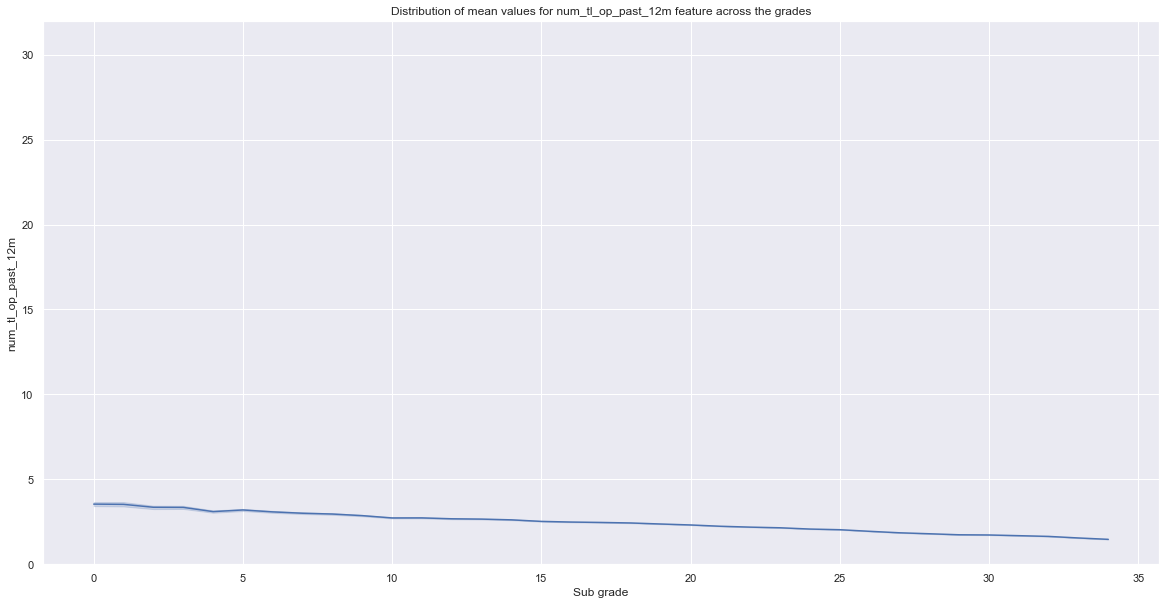

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=df, x="sub_grade", y="num_tl_op_past_12m", markers=True)
ax.set(xlabel="Sub grade", ylabel="num_tl_op_past_12m")
ax.set_title(
    "Distribution of mean values for num_tl_op_past_12m feature across the grades"
)
ax.set_ylim([df["num_tl_op_past_12m"].min(), df["num_tl_op_past_12m"].max()])
plt.show()

Num_tl_op_past_12m feature (Number of accounts currently 120 days past due, updated in past 2 months) also seem to be lower for the higher grades

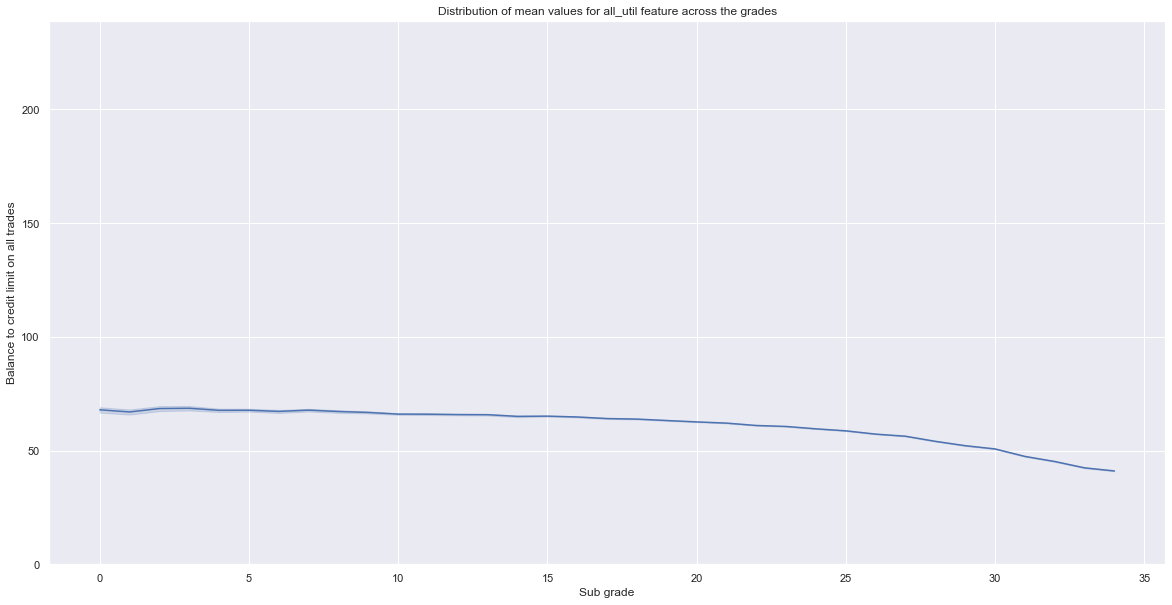

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=df, x="sub_grade", y="all_util", markers=True)
ax.set(xlabel="Sub grade", ylabel="Balance to credit limit on all trades")
ax.set_title("Distribution of mean values for all_util feature across the grades")
ax.set_ylim([df["all_util"].min(), df["all_util"].max()])
plt.show()

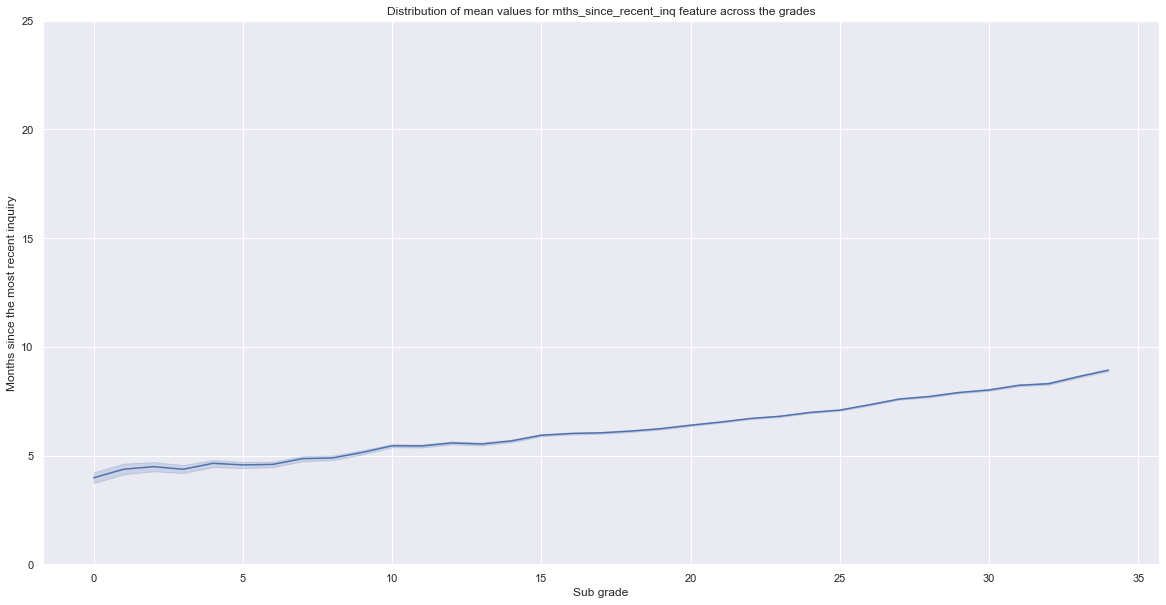

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=df, x="sub_grade", y="mths_since_recent_inq", markers=True)
ax.set(xlabel="Sub grade", ylabel="Months since the most recent inquiry")
ax.set_title(
    "Distribution of mean values for mths_since_recent_inq feature across the grades"
)
ax.set_ylim([df["mths_since_recent_inq"].min(), df["mths_since_recent_inq"].max()])
plt.show()

mths_since_recent_inq feature seems to be quite important - the mean value for A grade for it is almost twice as the value for G grade.

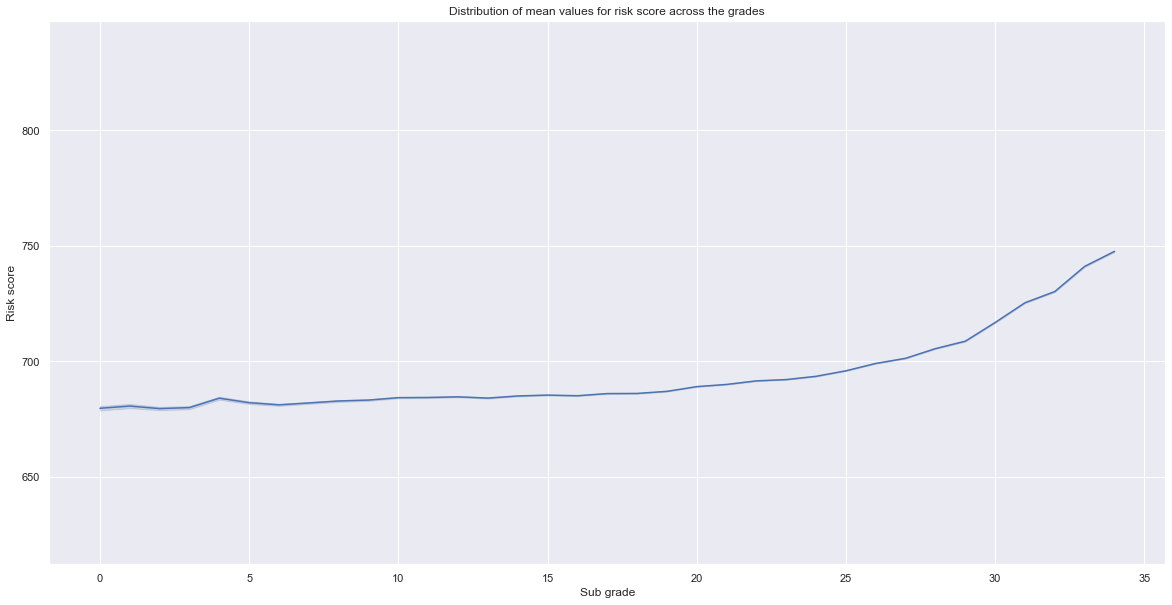

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=df, x="sub_grade", y="risk_score", markers=True)
ax.set(xlabel="Sub grade", ylabel="Risk score")
ax.set_title("Distribution of mean values for risk score across the grades")
ax.set_ylim([df["risk_score"].min(), df["risk_score"].max()])
plt.show()

Unsuprisingly the risk score also seems to be quite important.

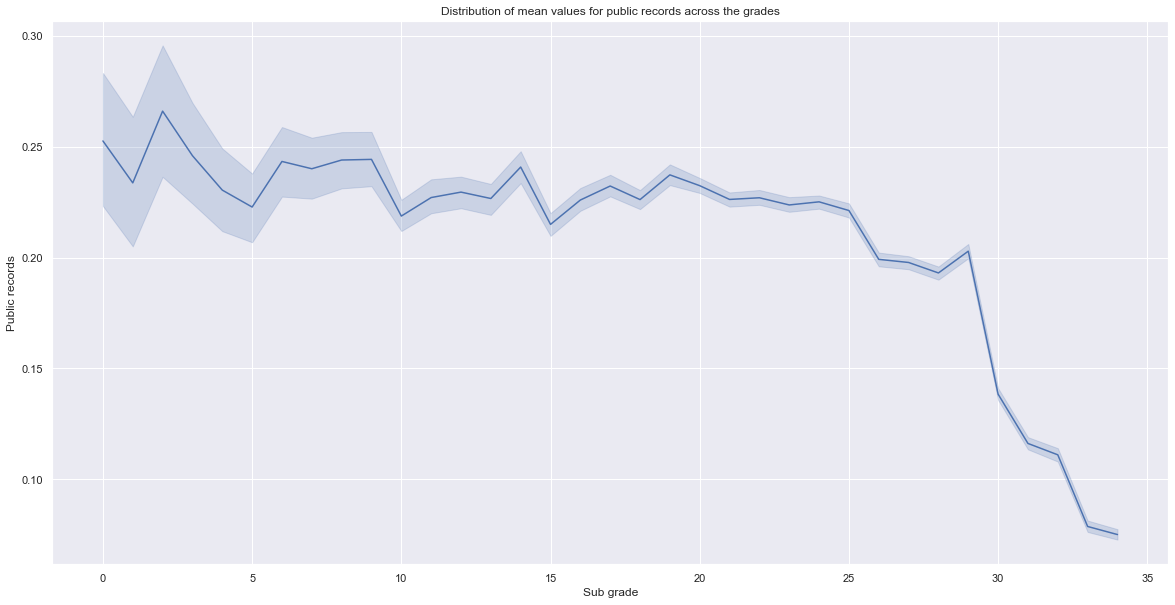

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=df, x="sub_grade", y="pub_rec", markers=True)
ax.set(xlabel="Sub grade", ylabel="Public records")
ax.set_title("Distribution of mean values for public records across the grades")
plt.show()

For this and the last graph, since the columns are very heavily skewed, I decided to zoom in on the difference, not show the whole scale.

Unsuprisingly having a public record brings your grade down. Interesting thing to notice - the mean seems to be quite similar for grades G to C and only changes for B and A.

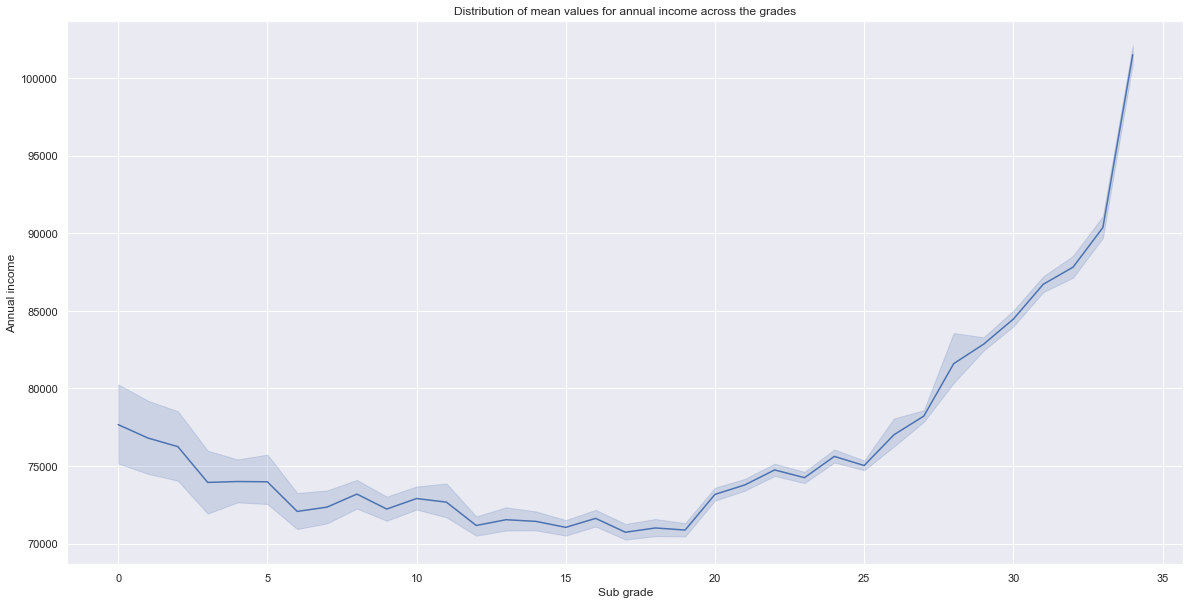

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=df, x="sub_grade", y="annual_inc", markers=True)
ax.set(xlabel="Sub grade", ylabel="Annual income")
ax.set_title("Distribution of mean values for annual income across the grades")
plt.show()

Same trend can be seen for the Annual income feature - It does seem to matter, but mostly for grades A and B

## Data cleaning and engineering

Now let's see what we can do about the missing data. Since during EDA we dropped some columns that might be useful for us, we'll reload our data. We'll also set aside sub_grade and int_rate columns - we'll need those for the third task.

In [ ]:
df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

sub_grade = df["sub_grade"]
int_rate = df["int_rate"]

df = df.loc[:, original_columns + ["disbursement_method"]]
df = clean_data_2_2(df)

df = df.drop(
    df.columns[df.columns.str.contains("joint") | df.columns.str.contains("sec_")],
    axis=1,
)

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_34072\1198342387.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")


There are a lot of columns in the dataset - it's possible that at least some of them have been introduced to the dataset later and that could explain at least some of our missing data.

In [ ]:
earliest_values = pd.Series(dtype="float64")
for column in df.columns:
    earliest_values[column] = df.loc[~df[column].isna(), "issue_d"].min()
earliest_values = earliest_values.to_frame()

earliest_values["missing_data"] = df.isna().sum()
earliest_values = earliest_values.rename(columns={0: "earliest_value"}).sort_values(
    ["earliest_value", "missing_data"]
)

for column in df.columns:
    earliest_values.loc[column, "missing_after"] = (
        df.loc[df["issue_d"] > earliest_values.loc[column, "earliest_value"], column]
        .isna()
        .sum()
    )

earliest_values[
    earliest_values["missing_data"] > earliest_values["missing_after"] * 3
].shape[0]

50

We can see that for 50 columns the majority of their missing data is in applications originating before they were introduced. Let's take a look at some of them!

In [ ]:
earliest_values["missing_after_2015"] = (
    df.loc[df["issue_d"] > pd.to_datetime("2015-12")].isna().sum()
)
(
    earliest_values["missing_after_2015"].sum()
    * 100
    / earliest_values["missing_data"].sum()
).round(2)

24.15

If we decide to drop applications that originate before the end of 2015, only 24 % of the missing values remain.

In [ ]:
earliest_values.sort_values("missing_after", ascending=False).head(10)

,earliest_value,missing_data,missing_after,missing_after_2015
mths_since_last_record,2007-06-01,1901512,1901491.0,1151136
mths_since_recent_bc_dlq,2012-08-01,1740967,1670053.0,1061159
mths_since_last_major_derog,2012-08-01,1679893,1608937.0,1014176
mths_since_recent_revol_delinq,2012-03-01,1520309,1469838.0,923819
mths_since_last_delinq,2007-06-01,1158502,1158481.0,704160
mths_since_recent_inq,2012-03-01,295435,245368.0,158741
il_util,2015-12-01,1068850,200027.0,200027
emp_title,2007-06-01,166969,166964.0,115496
emp_length_years,2007-06-01,146907,146907.0,102072
num_tl_120dpd_2m,2012-08-01,153657,83461.0,56035


And if we look at the features with the highest remaining missing value count in these 22%, we can see that a lot of them are features with "amount_of_months_since_X" values. For these features the presence of missing values is easily explainable - If you've never had a public record, value in mths_since_last_record column will be missing for you. We'll deal with these features by either binarizing them on whether the value is missing or not, or by imputing the missing values with an extremely large value.

In [ ]:
months_columns = df.columns[
    df.columns.str.contains("mths_since_") | df.columns.str.contains("mo_sin_")
]
other_columns = df.columns[~df.columns.isin(months_columns)]

In [ ]:
(df.loc[:, months_columns].isna().sum() * 100 / df.shape[0]).sort_values(
    ascending=False
)

mths_since_last_record            84.112837
mths_since_recent_bc_dlq          77.011175
mths_since_last_major_derog       74.309585
mths_since_recent_revol_delinq    67.250432
mths_since_last_delinq            51.246003
mths_since_rcnt_il                40.250227
mths_since_recent_inq             13.068482
mo_sin_old_il_acct                 6.151766
mths_since_recent_bc               3.247359
mo_sin_old_rev_tl_op               3.108683
mo_sin_rcnt_rev_tl_op              3.108683
mo_sin_rcnt_tl                     3.108639
mths_since_earliest_cr_line        0.001283
dtype: float64

In [ ]:
(
    earliest_values.loc[other_columns, "missing_after_2015"].sum()
    * 100
    / earliest_values.loc[other_columns, "missing_data"].sum()
).round(2)

3.85

We can see that if we exclude the mths_since columns, the missing data amount is only 3.8% of the original number - a huge decrease. We'll be dropping the applications that are before the december of 2015.

In [ ]:
df = df.loc[df["issue_d"] > pd.to_datetime("2015-12")]

(df.loc[:, other_columns].isna().sum() * 100 / df.shape[0]).sort_values(
    ascending=False
).head(10)

il_util             14.566190
emp_title            8.410548
emp_length_years     7.432997
num_tl_120dpd_2m     4.080531
bc_util              1.280632
percent_bc_gt_75     1.239415
bc_open_to_buy       1.235556
dti                  0.124451
revol_util           0.094667
all_util             0.020390
dtype: float64

There are still some values missing that we have to deal with. For the columns with a lot of missing data, we will check whether they have a high correlation with any of the other columns, including the ones we are dropping to avoid multicollinearity, and impute the values using those. We will fill the rest of the missing values with column median.

Now that the missing data has been dealt with, let's get to training!

In [ ]:
df = df.drop("issue_d", axis=1)
df = df.drop(df[df["zip_code"].isna()].index)

## Model training

In [ ]:
df2 = df.copy()
df = df2.sample(frac=0.1, random_state=42)

We will once again be using a sample from the whole dataset to speed up the preliminary training.

In [ ]:
train_set, test_set, train_grade, test_grade = train_test_split(
    df.loc[:, df.columns[df.columns != "grade"]],
    df["grade"],
    test_size=0.2,
    random_state=42,
    stratify=df["grade"],
)

In [ ]:
columns_to_drop = columns_to_drop_due_multicoll(train_set)
best_corrs_means_dict, max_corr_pairs = get_best_corrs_missing_cols(
    train_set, months_columns, columns_to_drop
)
negative_corr_careers, positive_corr_careers = get_positive_negative_careers(train_set)
train_set = train_set.drop("sub_grade", axis=1)

desc = train_set.describe()
skewed_columns = train_set.loc[:, ~(train_set.dtypes == "object")].columns[
    train_set.skew() > 1
]

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3600\503426307.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["emp_title"] = df["emp_title"].str.lower().str.replace('[^a-zA-Z0-9 ]', '')
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3600\503426307.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  prof_df = pd.Series([y for x in df["emp_title"].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').dropna() for y in x.split()]).value_counts().to_frame("total")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3600\503426307.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_words = pd.Series(name = "correlation")


I've made several utility functions that calculate values to be fed into pipeline. Columns_to_drop calculates which columns correlate too highly with each other and chooses the one that has a better correlation with the target column, get_best_corrs_missing_cols calculates best correlated features for each of the columns with a lot of missing data and also calculates values to impute, get_positive_negative_careers calculates which careers in "emp_title" column correlate positevily and negatively with the target column.

Preprocessing pipeline consists of:
    ZipStateToCoordinates - converts zip_code and state features into coordinates
    FilterCareers - Adds columns negative_corr_careers and positive_corr_careers based on whether the applicants career positively or negatively impacts loan grade
    SmallValuesToOther - Converts values in categorical features that have too small representation into a combined "other" feature
    FillMissingDataAccepted - Fills the missing data using the strategy I previously outlined
    TransformToLog - Transforms to log scale columns that are skewed
    OneHotPipeline - One hot encodes the remaining categorical features

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3600\317725514.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.median_impute = X1.loc[:, X1.columns[(~X1.columns.isin(self.columns_to_drop))]].median()


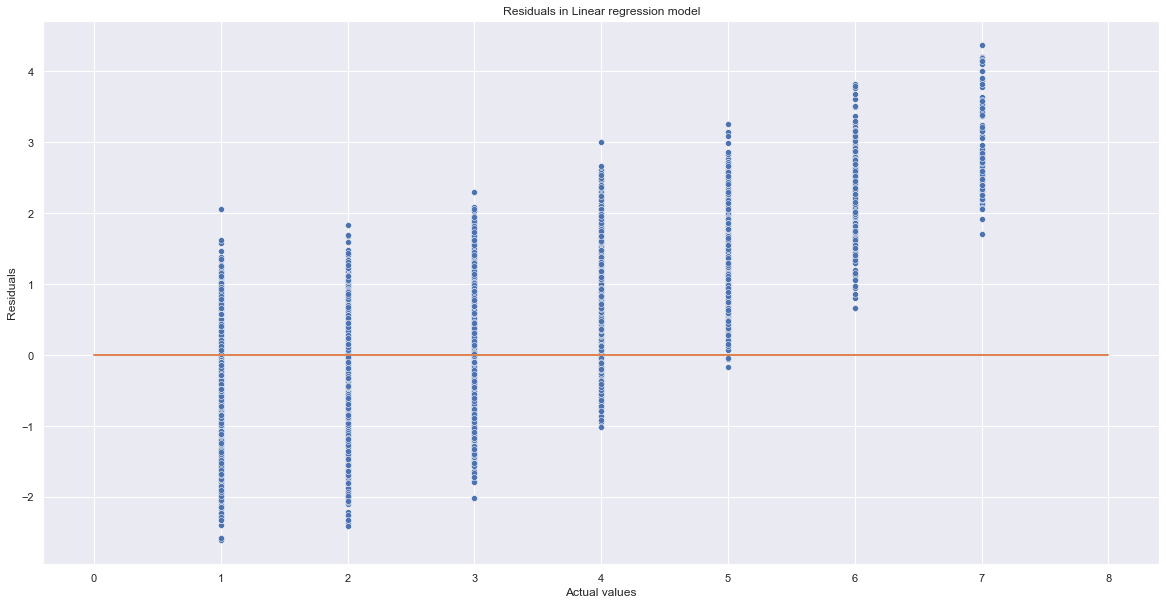

In [ ]:
one_hot_columns = [
    "term",
    "verification_status",
    "initial_list_status",
    "disbursement_method",
    "purpose",
    "home_ownership",
    "application_type",
]

OneHotPipeline = ColumnTransformer(
    [
        (
            "one_hot_columns",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            one_hot_columns,
        )
    ],
    remainder="passthrough",
)

Preprocessor = Pipeline(
    [
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        (
            "careers",
            FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title"),
        ),
        ("filter_values_columns", SmallValuesToOther(["purpose", "home_ownership"])),
        (
            "fill_missing_data",
            FillMissingDataAccepted(
                best_corrs_means_dict, max_corr_pairs, months_columns, columns_to_drop
            ),
        ),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline),
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", MinMaxScaler()),
        ("linear_reg", LinearRegression()),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    train_set, train_grade, test_size=0.2, random_state=42, stratify=train_grade
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([0, 8], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [ ]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.5008934478165001

The r2 value is 0.50 - not great, not terrible. However, since we are predicting discrete data, we need to round the fractions to integers.

In [ ]:
predictions = full_pipe.predict(test_set_val)
predictions = np.round(predictions)
predictions[predictions < 1] = 1
predictions[predictions > 7] = 7

r2_score(test_grade_val, predictions)

0.4480893631699713

And after doing that, the r2 score is a bit worse.

Next let's check which features were the most important for the model.

In [ ]:
temp = Preprocessor.steps[3][1].column_names
column_names = np.concatenate(
    [
        Preprocessor.steps[4][1].transformers_[0][1].get_feature_names_out(),
        temp[~temp.isin(Preprocessor.steps[4][1].transformers_[0][2])],
    ]
)

coefficients = pd.Series(full_pipe[-1].coef_, index=column_names)
coefficients = coefficients.loc[np.abs(coefficients).sort_values(ascending=False).index]

coefficients[:15]

max_bal_bc           -3.104222
tot_hi_cred_lim      -2.059334
annual_inc           -1.910959
mths_since_rcnt_il    1.881905
risk_score           -1.819834
delinq_2yrs           1.715886
num_tl_op_past_12m    1.521810
mo_sin_old_il_acct   -1.468609
dti                   1.390759
num_tl_90g_dpd_24m   -1.141421
open_act_il          -1.109952
il_util               1.094384
total_bal_il         -1.061800
term_ 60 months       0.982145
pub_rec               0.933784
dtype: float64

We can see that annual income, risk score and dti are important in the model, however the most important features seem to be maximum current balance owed on all accounts and total high credit limit

[17:52:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




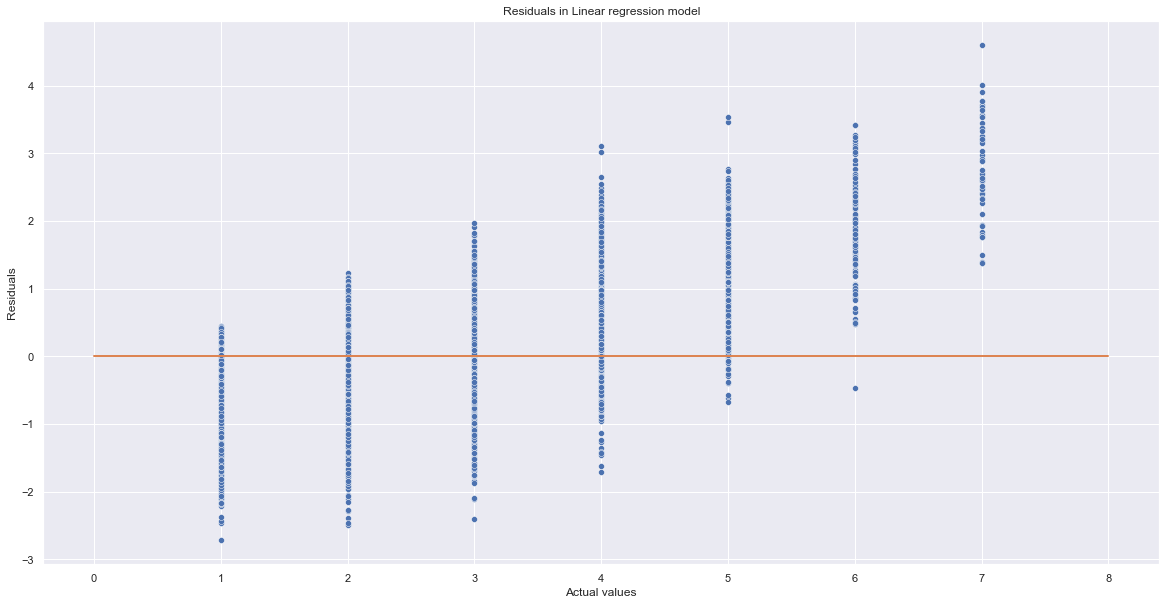

In [ ]:
Preprocessor = Pipeline(
    [
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        (
            "careers",
            FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title"),
        ),
        ("filter_values_columns", SmallValuesToOther(["purpose", "home_ownership"])),
        (
            "fill_missing_data",
            FillMissingDataAccepted(
                best_corrs_means_dict,
                max_corr_pairs,
                months_columns,
                columns_to_drop,
                binarize="all",
            ),
        ),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline),
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", RobustScaler()),
        (
            "model",
            xg.XGBRegressor(
                objective="reg:squarederror",
                n_estimators=227,
                seed=42,
                max_depth=6,
                learning_rate=0.13397,
                min_impurity_decrease=0.054034,
            ),
        ),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    train_set, train_grade, test_size=0.2, random_state=42, stratify=train_grade
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([0, 8], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [ ]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.5457846786403132

In [ ]:
predictions = full_pipe.predict(test_set_val)
predictions = np.round(predictions)
predictions[predictions < 1] = 1
predictions[predictions > 7] = 7

r2_score(test_grade_val, predictions)

0.49203088034845066

Using XGBoost we get slightly better values. Let's try tuning the hyperparameters.

In [ ]:
models = {}
grade_wrapper = lambda trial: objective_booster(trial, train_set, train_grade)
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(grade_wrapper, n_trials=50)

We get an even better value - 0.5490. Let's train it on the whole dataset.

In [ ]:
df = df2.copy()

In [ ]:
train_set, test_set, train_grade, test_grade = train_test_split(
    df.loc[:, df.columns[df.columns != "grade"]],
    df["grade"],
    test_size=0.2,
    random_state=42,
    stratify=df["grade"],
)

In [ ]:
columns_to_drop = columns_to_drop_due_multicoll(train_set)
best_corrs_means_dict, max_corr_pairs = get_best_corrs_missing_cols(
    train_set, months_columns, columns_to_drop
)
negative_corr_careers, positive_corr_careers = get_positive_negative_careers(train_set)
train_set = train_set.drop("sub_grade", axis=1)

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3312\503426307.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["emp_title"] = df["emp_title"].str.lower().str.replace('[^a-zA-Z0-9 ]', '')
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3312\503426307.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  prof_df = pd.Series([y for x in df["emp_title"].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').dropna() for y in x.split()]).value_counts().to_frame("total")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_3312\503426307.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_words = pd.Series(name = "correlation")


C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[18:19:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




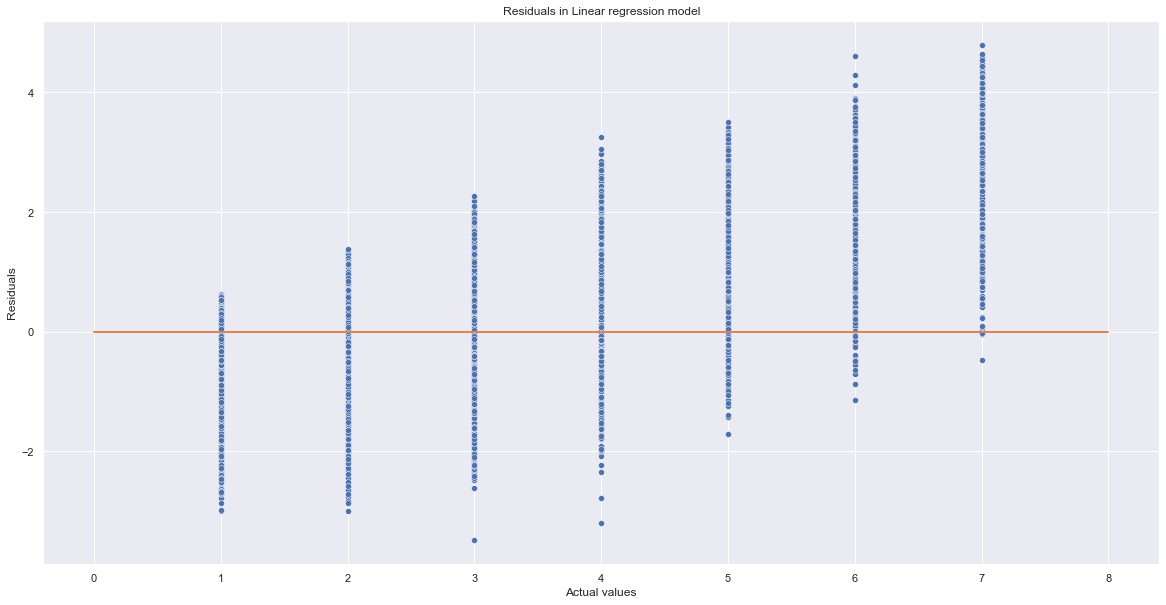

In [ ]:
Preprocessor = Pipeline(
    [
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        (
            "careers",
            FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title"),
        ),
        ("filter_values_columns", SmallValuesToOther(["purpose", "home_ownership"])),
        (
            "fill_missing_data",
            FillMissingDataAccepted(
                best_corrs_means_dict,
                max_corr_pairs,
                months_columns,
                columns_to_drop,
                binarize="all",
            ),
        ),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline),
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", RobustScaler()),
        (
            "model",
            xg.XGBRegressor(
                objective="reg:squarederror",
                n_estimators=227,
                seed=42,
                max_depth=6,
                learning_rate=0.13397,
                min_impurity_decrease=0.054034,
            ),
        ),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    train_set, train_grade, test_size=0.2, random_state=42, stratify=train_grade
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([0, 8], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [ ]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.5852352578000566

In [ ]:
predictions = full_pipe.predict(test_set_val)
predictions = np.round(predictions)
predictions[predictions < 1] = 1
predictions[predictions > 7] = 7

r2_score(test_grade_val, predictions)

0.530366948778006

After training on the whole dataset we get 4 % more on both the original r2 score and the r2 score after the predictions were rounded to ints.

In [ ]:
joblib.dump(full_pipe, "models//trained_model_grade.pkl")

['models//trained_model_grade.pkl']

## Third task

Our third task is to predict the subgrade and the interest rate for each application. Since we will be using the same data as for the second task, no additional EDA and Data cleaning is necesarry.

We'll start with the subgrade. To allow the model to concentrate on local differences, not differences between grades, we will be training a seperate model for each grade.

In [ ]:
df = df2.copy()

In [ ]:
train_set, test_set = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["sub_grade"],
)

In [ ]:
columns_to_drop = columns_to_drop_due_multicoll(train_set)
best_corrs_means_dict, max_corr_pairs = get_best_corrs_missing_cols(
    train_set, months_columns, columns_to_drop
)
negative_corr_careers, positive_corr_careers = get_positive_negative_careers(train_set)

desc = train_set.describe()
skewed_columns = train_set.loc[:, (train_set.dtypes == "float")].columns[
    train_set.loc[:, (train_set.dtypes == "float")].skew() > 1
]

The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
pd.options.mode.chained_assignment = None

To speed up the training process, we will again take samples of the data in cases where the data count is large.

In [ ]:
for grade in train_set["grade"].unique():

    temp_df = train_set.loc[train_set["grade"] == grade]

    if temp_df.shape[0] > 60000:
        temp_df = temp_df.sample(60000)

    temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")

    temp_df_target = temp_df["sub_grade"]
    temp_df = temp_df.drop(["sub_grade", "grade"], axis=1)

    models = {}
    grade_wrapper = lambda trial: objective_booster(trial, temp_df, temp_df_target)
    optuna_booster = optuna.create_study(direction="maximize")
    optuna_booster.optimize(grade_wrapper, n_trials=50)
    joblib.dump(optuna_booster, f"optuna_{grade}_sub_grades.pkl")
    best_model = models[optuna_booster.best_trial.number]
    joblib.dump(best_model, f"best_optuna_{grade}_sub_grades.pkl")

In [ ]:
model_params_sub_grades_dict = {
    3: {
        "scaler": "Standard",
        "state": True,
        "binarize": "none",
        "learning_rate": 0.10731549925206696,
        "n_estimators": 291,
        "max_depth": 4,
        "min_impurity_decrease": 0.05702454179955736,
    },
    2: {
        "scaler": "Robust",
        "state": True,
        "binarize": "none",
        "learning_rate": 0.07858196902630885,
        "n_estimators": 159,
        "max_depth": 6,
        "min_impurity_decrease": 0.018523924289356904,
    },
    1: {
        "scaler": "MinMax",
        "state": True,
        "binarize": "none",
        "learning_rate": 0.061505913211593266,
        "n_estimators": 251,
        "max_depth": 6,
        "min_impurity_decrease": 0.034627647433732804,
    },
    4: {
        "scaler": "MinMax",
        "state": True,
        "binarize": "all",
        "learning_rate": 0.034356662573556254,
        "n_estimators": 225,
        "max_depth": 6,
        "min_impurity_decrease": 0.04963477923772864,
    },
    5: {
        "scaler": "MinMax",
        "state": True,
        "binarize": "none",
        "learning_rate": 0.03616613969301015,
        "n_estimators": 242,
        "max_depth": 6,
        "min_impurity_decrease": 0.023097762494054125,
    },
    6: {
        "scaler": "Standard",
        "state": True,
        "binarize": "some",
        "learning_rate": 0.025113573741854914,
        "n_estimators": 255,
        "max_depth": 3,
        "min_impurity_decrease": 0.04558618428699177,
    },
    7: {
        "scaler": "Standard",
        "state": True,
        "binarize": "none",
        "learning_rate": 0.058183498807458156,
        "n_estimators": 206,
        "max_depth": 2,
        "min_impurity_decrease": 0.01638810703830247,
    },
}

In [ ]:
subgrades = pd.Series(index=[i for i in range(1, 8)], name="score")
for grade in train_set["grade"].unique():

    temp_df = train_set.loc[train_set["grade"] == grade]

    if temp_df.shape[0] > 60000:
        temp_df = temp_df.sample(60000)

    temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")

    temp_df_target = temp_df["sub_grade"]
    temp_df = temp_df.drop(["sub_grade", "grade"], axis=1)

    model_params = model_params_sub_grades_dict[grade]
    if model_params["scaler"] == "MinMax":
        scaler = MinMaxScaler()
    elif model_params["scaler"] == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    one_hot_columns = [
        "term",
        "verification_status",
        "initial_list_status",
        "disbursement_method",
        "purpose",
        "home_ownership",
        "application_type",
    ]

    OneHotPipeline = ColumnTransformer(
        [
            (
                "one_hot_columns",
                OneHotEncoder(drop="first", handle_unknown="ignore"),
                one_hot_columns,
            )
        ],
        remainder="passthrough",
    )

    Preprocessor = Pipeline(
        [
            (
                "zip_to_coords",
                ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
            ),
            (
                "careers",
                FilterCareers(
                    negative_corr_careers, positive_corr_careers, "emp_title"
                ),
            ),
            (
                "filter_values_columns",
                SmallValuesToOther(["purpose", "home_ownership"]),
            ),
            (
                "fill_missing_data",
                FillMissingDataAccepted(
                    best_corrs_means_dict,
                    max_corr_pairs,
                    months_columns,
                    columns_to_drop,
                    binarize=model_params["binarize"],
                ),
            ),
            ("log_transform", TransformToLog(skewed_columns)),
            ("one_hot_encode", OneHotPipeline),
        ]
    )

    full_pipe = Pipeline(
        [
            ("preprocessor", Preprocessor),
            ("scaler", scaler),
            (
                "model",
                xg.XGBRegressor(
                    objective="reg:squarederror",
                    n_estimators=model_params["n_estimators"],
                    seed=42,
                    max_depth=model_params["max_depth"],
                    learning_rate=model_params["learning_rate"],
                    min_impurity_decrease=model_params["min_impurity_decrease"],
                ),
            ),
        ]
    )

    train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
        temp_df, temp_df_target, test_size=0.2, random_state=42
    )

    full_pipe.fit(train_set_val, train_grade_val)

    subgrades[grade] = r2_score(test_grade_val, full_pipe.predict(test_set_val))

In [ ]:
subgrades

1    0.362061
2    0.121142
3    0.064895
4    0.052557
5    0.158674
6    0.059345
7    0.104205
Name: score, dtype: float64

The r2 score varies quite a lot between the grades, but even for the best the score is low. This might be a good area to improve in the future, but for now we will train these models on the whole data and save them.

In [ ]:
for grade in train_set["grade"].unique():

    temp_df = train_set.loc[train_set["grade"] == grade]

    temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")

    temp_df_target = temp_df["sub_grade"]
    temp_df = temp_df.drop(["sub_grade", "grade"], axis=1)

    model_params = model_params_sub_grades_dict[grade]
    if model_params["scaler"] == "MinMax":
        scaler = MinMaxScaler()
    elif model_params["scaler"] == "Standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    Preprocessor = Pipeline(
        [
            (
                "zip_to_coords",
                ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
            ),
            (
                "careers",
                FilterCareers(
                    negative_corr_careers, positive_corr_careers, "emp_title"
                ),
            ),
            (
                "filter_values_columns",
                SmallValuesToOther(["purpose", "home_ownership"]),
            ),
            (
                "fill_missing_data",
                FillMissingDataAccepted(
                    best_corrs_means_dict,
                    max_corr_pairs,
                    months_columns,
                    columns_to_drop,
                    binarize=model_params["binarize"],
                ),
            ),
            ("log_transform", TransformToLog(skewed_columns)),
            ("one_hot_encode", OneHotPipeline),
        ]
    )

    full_pipe = Pipeline(
        [
            ("preprocessor", Preprocessor),
            ("scaler", scaler),
            (
                "model",
                xg.XGBRegressor(
                    objective="reg:squarederror",
                    n_estimators=model_params["n_estimators"],
                    seed=42,
                    max_depth=model_params["max_depth"],
                    learning_rate=model_params["learning_rate"],
                    min_impurity_decrease=model_params["min_impurity_decrease"],
                ),
            ),
        ]
    )

    full_pipe.fit(temp_df, temp_df_target)

    joblib.dump(full_pipe, f"models//trained_model_{grade}_sub_grades.pkl")

To predict int_rate as one of the features we will be using the grade column as predicted by the model we built previously. Since the quality of the subgrade models was so low, I decided against using them.

In [ ]:
grade_pipe = joblib.load("models//trained_model_grade.pkl")

In [ ]:
train_set["grade"] = grade_pipe.predict(train_set)
train_set.loc[:, "int_rate"] = int_rate

temp_df = train_set.sample(frac=0.25)

temp_df_target = temp_df["int_rate"]
temp_df = temp_df.drop(["int_rate", "sub_grade"], axis=1)

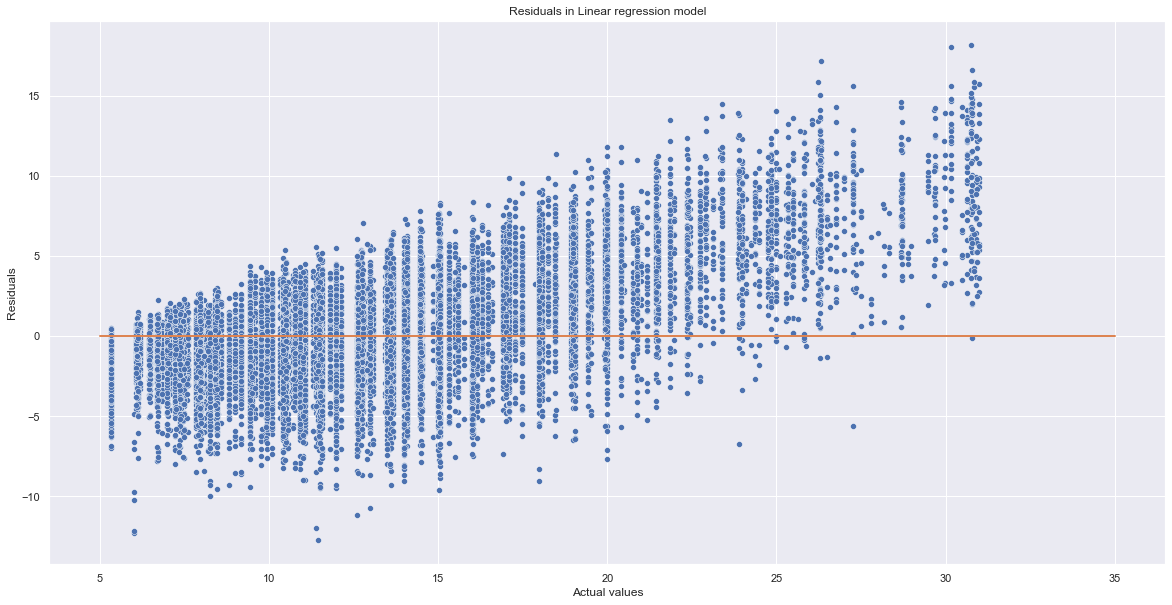

In [ ]:
one_hot_columns = [
    "term",
    "verification_status",
    "initial_list_status",
    "disbursement_method",
    "purpose",
    "home_ownership",
    "application_type",
]


OneHotPipeline = ColumnTransformer(
    [
        (
            "one_hot_columns",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            one_hot_columns,
        )
    ],
    remainder="passthrough",
)


Preprocessor = Pipeline(
    [
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        (
            "careers",
            FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title"),
        ),
        ("filter_values_columns", SmallValuesToOther(["purpose", "home_ownership"])),
        (
            "fill_missing_data",
            FillMissingDataAccepted(
                best_corrs_means_dict,
                max_corr_pairs,
                months_columns,
                columns_to_drop,
                binarize="all",
            ),
        ),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline),
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", RobustScaler()),
        (
            "model",
            xg.XGBRegressor(objective="reg:squarederror", n_estimators=100, seed=42),
        ),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    temp_df, temp_df_target, test_size=0.2, random_state=42
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([5, 35], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [ ]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.5813980129436152

We get an r2 score of 0.58. If we look at the residual graph we can see, that the model struggles to predict the higher interest rates, due to lower amount of data - we saw the same trend for predicting grade.

In [ ]:
models = {}
grade_wrapper = lambda trial: objective_booster(trial, temp_df, temp_df_target)
optuna_booster = optuna.create_study(direction="maximize")
optuna_booster.optimize(grade_wrapper, n_trials=200)
joblib.dump(optuna_booster, "optuna_int_rate.pkl")

We get a slightly better r2 value - 0.61446. Let's train the model using all of the data.

In [ ]:
temp_df = train_set.copy()

In [ ]:
temp_df_target = temp_df["int_rate"]
temp_df = temp_df.drop(["int_rate", "sub_grade"], axis=1)

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[09:57:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_impurity_decrease" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




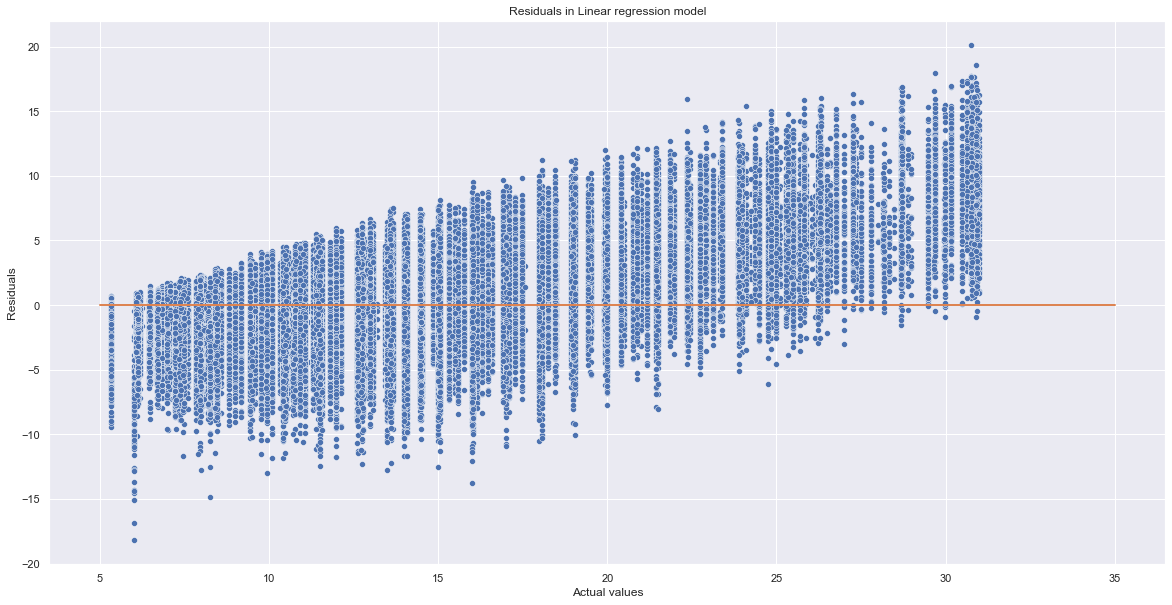

In [ ]:
one_hot_columns = [
    "term",
    "verification_status",
    "initial_list_status",
    "disbursement_method",
    "purpose",
    "home_ownership",
    "application_type",
]


OneHotPipeline = ColumnTransformer(
    [
        (
            "one_hot_columns",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            one_hot_columns,
        )
    ],
    remainder="passthrough",
)


Preprocessor = Pipeline(
    [
        (
            "zip_to_coords",
            ZipStateToCoordinates(state_coord_means, bin_coord_means, state=True),
        ),
        (
            "careers",
            FilterCareers(negative_corr_careers, positive_corr_careers, "emp_title"),
        ),
        ("filter_values_columns", SmallValuesToOther(["purpose", "home_ownership"])),
        (
            "fill_missing_data",
            FillMissingDataAccepted(
                best_corrs_means_dict,
                max_corr_pairs,
                months_columns,
                columns_to_drop,
                binarize="some",
            ),
        ),
        ("log_transform", TransformToLog(skewed_columns)),
        ("one_hot_encode", OneHotPipeline),
    ]
)

full_pipe = Pipeline(
    [
        ("preprocessor", Preprocessor),
        ("scaler", StandardScaler()),
        (
            "model",
            xg.XGBRegressor(
                objective="reg:squarederror",
                seed=42,
                learning_rate=0.1444,
                n_estimators=280,
                max_depth=6,
                min_impurity_decrease=0.078558,
            ),
        ),
    ]
)

train_set_val, test_set_val, train_grade_val, test_grade_val = train_test_split(
    temp_df, temp_df_target, test_size=0.2, random_state=42
)

full_pipe.fit(train_set_val, train_grade_val)


plt.figure(figsize=(20, 10))
ax = sns.scatterplot(
    x=test_grade_val, y=test_grade_val - full_pipe.predict(test_set_val)
)
plt.plot([5, 35], [0, 0], linewidth=2, color=colors["orange"])
ax.set_xlabel("Actual values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals in Linear regression model")
plt.show()

In [ ]:
r2_score(test_grade_val, full_pipe.predict(test_set_val))

0.6238755643046976

Using the whole dataset we get an even better r2 score.

In [ ]:
joblib.dump(full_pipe, "models//trained_model_int_rate.pkl")

['models//trained_model_int_rate.pkl']

## Testing

Let's test our models now!

In [ ]:
int_rate_pipe = joblib.load("models//trained_model_int_rate.pkl")

In [ ]:
predictions = grade_pipe.predict(test_set.drop(["grade", "sub_grade"], axis=1))
predictions = np.round(predictions)
predictions[predictions < 1] = 1
predictions[predictions > 7] = 7

r2_score(test_set["grade"], predictions)

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.5417618292130579

Given that we had to round the results to ints, the score for model predicting grade is actually even slightly better than what we got previously.

In [ ]:
subgrades = pd.Series(index=[i for i in range(1, 8)], name="score")
for grade in test_set["grade"].unique():

    temp_df = test_set.loc[test_set["grade"] == grade]

    temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")

    temp_df_target = temp_df["sub_grade"]
    temp_df = temp_df.drop(["sub_grade", "grade"], axis=1)

    sub_grade_pipe = joblib.load(f"models//trained_model_{grade}_sub_grades.pkl")

    r2_score(temp_df_target, grade_pipe.predict(temp_df))
    predictions = grade_pipe.predict(temp_df)
    predictions = np.round(predictions)
    predictions[predictions < 1] = 1
    predictions[predictions > 5] = 5

    subgrades[grade] = r2_score(temp_df_target, predictions)

subgrades

C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2294241847.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  subgrades = pd.Series(index=[i for i in range(1,8)], name="score")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2294241847.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
C:\Users\Ausmints\AppData\Local\Temp\ipykernel_13124\2294241847.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df.loc[:, "sub_grade"] = sub_grade.str.replace(r"[A-Z]", "").astype("float")
C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users

1   -0.926215
2   -0.228720
3   -0.010974
4   -0.327383
5   -0.469966
6   -1.534331
7   -1.693391
Name: score, dtype: float64

In [ ]:
subgrades

1   -0.920797
2   -0.231630
3   -0.012917
4   -0.332643
5   -0.481065
6   -1.529187
7   -1.699055
Name: score, dtype: float64

While the scores for subgrades on the train data weren't anything to write home about, they're actually negative on the test data. Maybe our plan to focus on local differences led to overfitting?

In [ ]:
test_set["grade"] = grade_pipe.predict(test_set)
test_set.loc[:, "int_rate"] = int_rate

temp_df = test_set.copy()

temp_df_target = temp_df["int_rate"]
temp_df = temp_df.drop(["int_rate", "sub_grade"], axis=1)

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
r2_score(temp_df_target, int_rate_pipe.predict(temp_df))

C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Ausmints\anaconda3\envs\Lending_club\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.6253064345694954

And finally, the score for model predicting interest rate is slightly better than it was on the training data.

## What could be improved

* Make a seperate EDA for each grade when training models for subgrades - maybe some features are more important for some grades than for others
* Reduce the amount of features
* Do more data engineering with text columns - emp_title, desc